In [1]:
import pandas as pd 

In [2]:
X0=pd.read_parquet('X_t0.parquet')
X1=pd.read_parquet('X_t1.parquet')
X2=pd.read_parquet('X_t2.parquet')
y0=pd.read_parquet('y_t0.parquet')
y1=pd.read_parquet('y_t1.parquet')

In [3]:
!pip install optuna



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [5]:
ys = ['target']
binary_columns = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
id_columns = ['borrow_block_number']
wallet = ['wallet_address']
time_columns = [
    'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
    'time_since_first_deposit', 'time_since_last_liquidated','borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']

# Columnas a escalar
columns_to_scale = list(X0.columns.difference(id_columns + binary_columns + time_columns + ys + wallet))

# Configurar el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', id_columns + binary_columns + time_columns)
    ]
)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0,random_state=17)

In [ ]:
pipeline = Pipeline([
    ('Preprocessing', preprocessor),
    ('XGBoost', XGBClassifier())
])

pipeline.fit(X_train, y_train)

In [32]:
X0p = preprocessor.fit_transform(X0)

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
import optuna

# Define tu función objetivo para maximizar aucpr
def objective_function(trial):
    # Define los hiperparámetros a optimizar
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
    }

    # Divide los datos en entrenamiento y validación
    X_train, X_test, y_train, y_test = train_test_split(X0p, y0, test_size=0.3, stratify=y0, random_state=17)

    # Entrena el modelo
    model = RandomForestClassifier(
        random_state=17,
        **params
    )
    
    model.fit(X_train, y_train)
    
    # Realiza predicciones de probabilidad
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calcula aucpr
    aucpr = average_precision_score(y_test, y_prob)

    return aucpr



In [52]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_function, n_trials=50)
print("Mejores parámetros:")
print(study.best_trial.params)

print(f"Mejor AUC-PR alcanzado: {study.best_trial.value}")

[I 2024-12-05 20:59:51,766] A new study created in memory with name: no-name-475aae2b-a032-499c-bfbc-03c1ac55b2c9
c:\Users\geral\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2024-12-05 21:00:04,060] Trial 0 finished with value: 0.8993577737663956 and parameters: {'n_estimators': 118, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8993577737663956.
c:\Users\geral\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2024-12-05 21:00:09,670] Trial 1 finished with value: 0.8594807600517772 and 

Mejores parámetros:
{'n_estimators': 293, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}
Mejor AUC-PR alcanzado: 0.9176663335114493


In [57]:
from sklearn.metrics import average_precision_score
from optuna.integration import XGBoostPruningCallback
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import optuna

# Define tu función objetivo para maximizar aucpr
def objective_function(trial):
    # Define los hiperparámetros a optimizar
    params = {
        "objective": "binary:logistic",  # Para clasificación binaria
        "eval_metric": "aucpr",  # Métrica usada durante el entrenamiento
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "n_estimators": trial.suggest_int("n_estimators", 10, 300),
    }

    # Divide los datos en entrenamiento y validación
    X_train, X_test, y_train, y_test = train_test_split(X0p, y0, test_size=0.3, stratify=y0, random_state=17)

    # Entrena el modelo
    pruning_callback = XGBoostPruningCallback(trial, observation_key="validation_0-aucpr")  # Cambio de clave

    model = XGBClassifier(seed=17,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=10,
        callbacks=[pruning_callback], **params)

    # Entrenar el modelo
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )
    
    # Realiza predicciones de probabilidad
    y_prob = model.predict_proba(X_test)[:, 1]  # Tomamos la probabilidad de la clase positiva
    
    # Calcula AUC-PR
    aucpr = average_precision_score(y_test, y_prob)
    
    return aucpr

# Crear el estudio Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective_function, n_trials=200)

# Mostrar los mejores parámetros y AUC-PR alcanzado
print("Mejores parámetros:")
print(study.best_trial.params)

print(f"Mejor AUC-PR alcanzado: {study.best_trial.value}")

[I 2024-12-05 22:10:29,934] A new study created in memory with name: no-name-f423a09f-82cc-49e1-ba32-76f16808176e
C:\Users\geral\AppData\Local\Temp\ipykernel_448\1409931155.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
c:\Users\geral\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:10:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_set" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-05 22:10:38,413] Trial 0 finished with value: 0.9654658630472769 and parameters: {'max_depth': 8, 'learning_rate': 0.09337870030465689, 'subsample': 0.7072729983555917, 'colsample_bytree': 0.7264884115076452, 'min_child_

Mejores parámetros:
{'max_depth': 8, 'learning_rate': 0.09337870030465689, 'subsample': 0.7072729983555917, 'colsample_bytree': 0.7264884115076452, 'min_child_weight': 1, 'gamma': 0.9069145536274531, 'n_estimators': 245}
Mejor AUC-PR alcanzado: 0.9654658630472769


In [58]:
# Definir los hiperparámetros de XGBoost
params = {
    'max_depth': 8,
    'learning_rate': 0.09337870030465689,
    'subsample': 0.7072729983555917,
    'colsample_bytree': 0.7264884115076452,
    'min_child_weight': 1,
    'gamma': 0.9069145536274531,
    'n_estimators': 245
}
# Dividir los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0, random_state=17)

# Crear el pipeline
pipeline = Pipeline([
    ('Preprocessing', preprocessor),
    ('classifier', XGBClassifier(**params, random_state=17))
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Realizar predicciones de probabilidad
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Calcular la métrica AUC PR
aucpr = average_precision_score(y_test, y_prob)

# Imprimir el resultado
print(f"AUC PR: {aucpr}")

AUC PR: 0.9664470892298799


In [60]:
import joblib
joblib.dump(pipeline, 'model_v1.pkl')

['model_v1.pkl']

In [61]:
# Cargar el modelo guardado
pipeline_new = joblib.load('model_v1.pkl')

# Re-entrenar el modelo con nuevos datos
pipeline_new.fit(X1, y1)

# Realizar nuevas predicciones con el modelo re-entrenado
y_prob_new = pipeline_new.predict_proba(X_test)[:, 1]

# Recalcular la métrica AUC PR después del re-entrenamiento
aucpr_new = average_precision_score(y_test, y_prob_new)
print(f"AUC PR (after re-training): {aucpr_new}")

AUC PR (after re-training): 0.8652992031281962


# Exportar para codalab

In [62]:
from zipfile import ZipFile
import os
def generateFiles(predict_data, clf_pipe):
    """Genera los archivos a subir en CodaLab

    Input
    ---------------
    predict_data: Dataframe con los datos de entrada a predecir
    clf_pipe: pipeline del clf

    Ouput
    ---------------
    archivo de txt
    """
    y_pred_clf = clf_pipe.predict_proba(predict_data)[:, 1]
    with open('./predictions.txt', 'w') as f:
        for item in y_pred_clf:
            f.write("%s\n" % item)
    
    with ZipFile('predictions.zip', 'w') as zipObj:
        zipObj.write('predictions.txt')
    os.remove('predictions.txt')

generateFiles(X2, pipeline_new)

# Con ETC

In [5]:
import pandas as pd
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

X0=pd.read_parquet('X_t0.parquet')
X1=pd.read_parquet('X_t1.parquet')
X2=pd.read_parquet('X_t2.parquet')
y0=pd.read_parquet('y_t0.parquet')
y1=pd.read_parquet('y_t1.parquet')

In [6]:
ys = ['target']
binary_columns = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
id_columns = ['borrow_block_number']
wallet = ['wallet_address']
time_columns = [
    'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
    'time_since_first_deposit', 'time_since_last_liquidated','borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']

# Columnas a escalar
columns_to_scale = list(X0.columns.difference(id_columns + binary_columns + time_columns + ys + wallet))

# Configurar el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', id_columns + binary_columns + time_columns)
    ]
)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0,random_state=17)

## Búsqueda de hiperparámetros

In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import joblib

# Definir las columnas
ys = ['target']
binary_columns = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
id_columns = ['borrow_block_number']
wallet = ['wallet_address']
time_columns = [
    'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
    'time_since_first_deposit', 'time_since_last_liquidated','borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']

# Columnas a escalar
columns_to_scale = list(X0.columns.difference(id_columns + binary_columns + time_columns + ys + wallet))

# Preprocesador para escalar las columnas necesarias y pasar a través las demás
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', id_columns + binary_columns + time_columns)
    ]
)

from sklearn.model_selection import train_test_split

# Dividir en conjunto de entrenamiento (train) y conjunto de prueba (test)
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0, random_state=17)

# Ahora, dividir el conjunto de entrenamiento (X_train, y_train) en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=17)

# Verificar tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

# Crear la función objetivo para Optuna
def objective(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])
    
    # Definir el modelo ExtraTreesClassifier con los hiperparámetros sugeridos
    model = ExtraTreesClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=123)
    
    # Crear el pipeline
    pipeline = Pipeline([
        ('preprocessing', preprocessor),   # Preprocesamiento
        ('smote', SMOTE(sampling_strategy='auto', random_state=123)),  # SMOTE para balanceo
        ('model', model)  # Modelo de clasificación
    ])
    
    # Entrenar el modelo
    pipeline.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de validación
    y_pred = pipeline.predict(X_test)
    
    # Calcular F1 score en el conjunto de test
    f1 = f1_score(y_test, y_pred)
    
    return f1  # Queremos maximizar F1

# Configurar y ejecutar el estudio Optuna
study = optuna.create_study(direction='maximize')  # Maximizar F1 score
study.optimize(objective, n_trials=50)  # Ejecutar 50 pruebas

# Mejor conjunto de parámetros encontrados
best_params = study.best_params
print(f'Mejores parámetros encontrados: {best_params}')

# Crear el modelo final con los mejores parámetros
final_model = ExtraTreesClassifier(**best_params, random_state=123)

# Crear el pipeline final con el preprocesador y SMOTE
final_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # Preprocesamiento
    ('smote', SMOTE(sampling_strategy='auto', random_state=123)),  # SMOTE para balanceo
    ('model', final_model)  # Modelo de clasificación
])

# Entrenar el modelo final
final_pipeline.fit(X_train, y_train)

# Guardar el escalador (transformador) para uso posterior
joblib.dump(final_pipeline.named_steps['preprocessing'], 'scaler.pkl')

# Evaluación final en el conjunto de test con la métrica F1
final_y_pred = final_pipeline.predict(X_test)
final_f1 = f1_score(y_test, final_y_pred)
print(f'Rendimiento final (F1) en X_test: {final_f1}')

In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las columnas
ys = ['target']
binary_columns = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
id_columns = ['borrow_block_number']
wallet = ['wallet_address']
time_columns = [
    'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
    'time_since_first_deposit', 'time_since_last_liquidated','borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']

# Columnas a escalar
columns_to_scale = list(X0.columns.difference(id_columns + binary_columns + time_columns + ys + wallet))

# Preprocesador para escalar las columnas necesarias y pasar a través las demás
preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), columns_to_scale),
                  ('passthrough', 'passthrough', id_columns + binary_columns + time_columns)]
)

# Dividir en conjunto de entrenamiento (train) y conjunto de prueba (test)
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0, random_state=17)

# Ahora, dividir el conjunto de entrenamiento (X_train, y_train) en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=17)

# Verificar tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

# Evaluación inicial sin optimización de parámetros
print("Evaluación inicial (sin optimizar parámetros):")
baseline_model = ExtraTreesClassifier(random_state=123)
baseline_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(sampling_strategy='auto', random_state=123)),
    ('model', baseline_model)
])
baseline_pipeline.fit(X_train, y_train)
baseline_y_pred = baseline_pipeline.predict(X_test)
baseline_f1 = f1_score(y_test, baseline_y_pred)
print(f"F1 score (sin optimizar parámetros): {baseline_f1}")

# Matriz de confusión inicial
cm = confusion_matrix(y_test, baseline_y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title("Matriz de Confusión Inicial (sin optimizar parámetros)")
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Crear la función objetivo para Optuna
def objective(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])

    # Definir el modelo ExtraTreesClassifier con los hiperparámetros sugeridos
    model = ExtraTreesClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=123)

    # Crear el pipeline
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('smote', SMOTE(sampling_strategy='auto', random_state=123)),
        ('model', model)
    ])

    # Entrenar el modelo
    pipeline.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de validación
    y_pred = pipeline.predict(X_val)

    # Calcular F1 score en el conjunto de validación
    f1 = f1_score(y_val, y_pred)

    # Mostrar el progreso de Optuna en tiempo real
    print(f"Trial {trial.number} - F1 score (validación): {f1}")

    # Retornar F1 score
    return f1

# Configurar y ejecutar el estudio Optuna
study = optuna.create_study(direction='maximize')  # Maximizar F1 score
study.optimize(objective, n_trials=50)  # Ejecutar 50 pruebas

# Mejor conjunto de parámetros encontrados
best_params = study.best_params
print(f'Mejores parámetros encontrados: {best_params}')

# Crear el modelo final con los mejores parámetros
final_model = ExtraTreesClassifier(**best_params, random_state=123)

# Crear el pipeline final con el preprocesador y SMOTE
final_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(sampling_strategy='auto', random_state=123)),
    ('model', final_model)
])

# Entrenar el modelo final
final_pipeline.fit(X_train, y_train)

# Evaluación final en el conjunto de prueba con la métrica F1
final_y_pred = final_pipeline.predict(X_test)
final_f1 = f1_score(y_test, final_y_pred)
print(f'Rendimiento final (F1) en X_test: {final_f1}')

# Matriz de confusión final
cm_final = confusion_matrix(y_test, final_y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title("Matriz de Confusión Final")
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()




Tamaño del conjunto de entrenamiento: 24805
Tamaño del conjunto de validación: 6202
Tamaño del conjunto de prueba: 13289
       target
9614        0
14259       1
4520        0
20004       1
32538       1
...       ...
26231       1
10736       1
35307       0
29777       1
30454       1

[24805 rows x 1 columns]


c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2024-12-06 00:18:53,189] A new study created in memory with name: no-name-7837ae36-7e4b-4619-8ebb-af141d8243f8


Rendimiento inicial (F1) en X_test: 0.8699585953074682


c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 0: 0.845191153780216


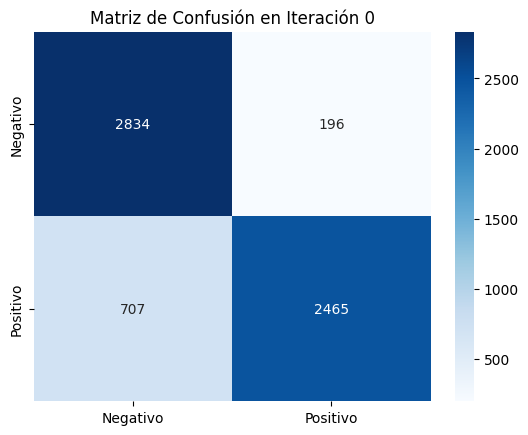

[I 2024-12-06 00:18:59,165] Trial 0 finished with value: 0.845191153780216 and parameters: {'n_estimators': 168, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 1: 0.8378332484292749


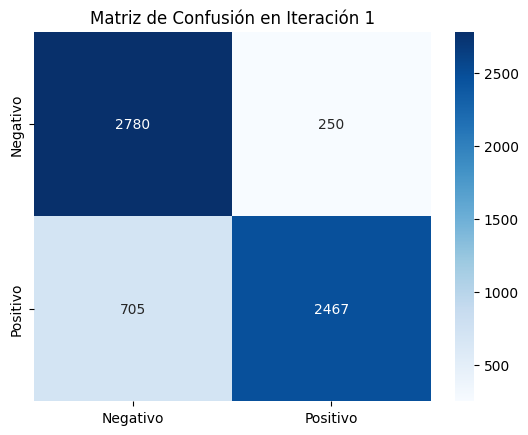

[I 2024-12-06 00:20:30,243] Trial 1 finished with value: 0.8378332484292749 and parameters: {'n_estimators': 476, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 2: 0.7951346655082537


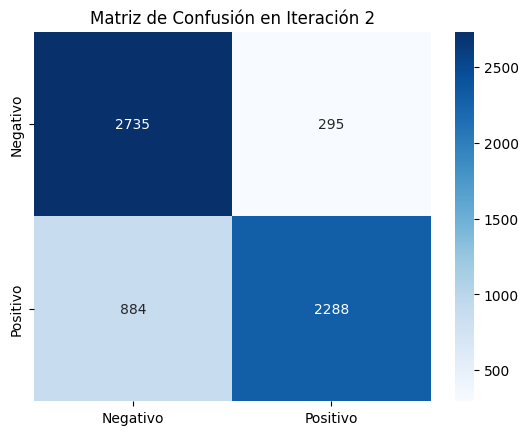

[I 2024-12-06 00:20:34,293] Trial 2 finished with value: 0.7951346655082537 and parameters: {'n_estimators': 161, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 3: 0.7478351229650156


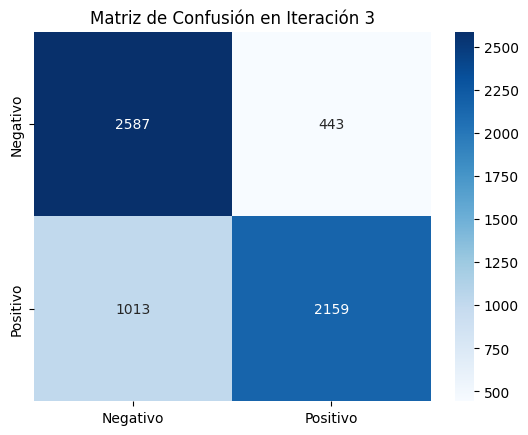

[I 2024-12-06 00:20:36,101] Trial 3 finished with value: 0.7478351229650156 and parameters: {'n_estimators': 164, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 4: 0.7445154603558473


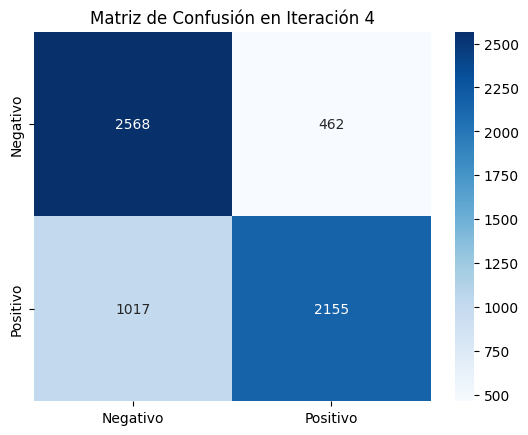

[I 2024-12-06 00:20:39,001] Trial 4 finished with value: 0.7445154603558473 and parameters: {'n_estimators': 290, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 5: 0.830959327269607


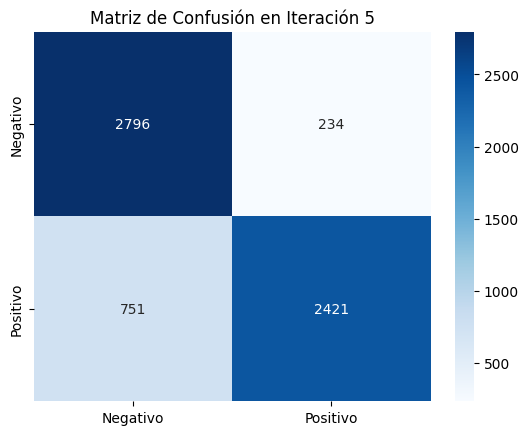

[I 2024-12-06 00:20:41,469] Trial 5 finished with value: 0.830959327269607 and parameters: {'n_estimators': 66, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 6: 0.8391370817054526


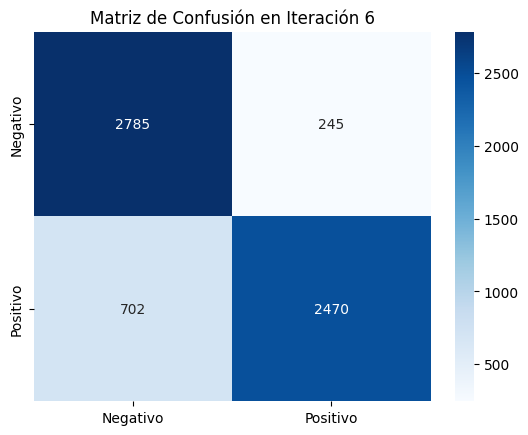

[I 2024-12-06 00:21:59,823] Trial 6 finished with value: 0.8391370817054526 and parameters: {'n_estimators': 398, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 7: 0.8284432171211599


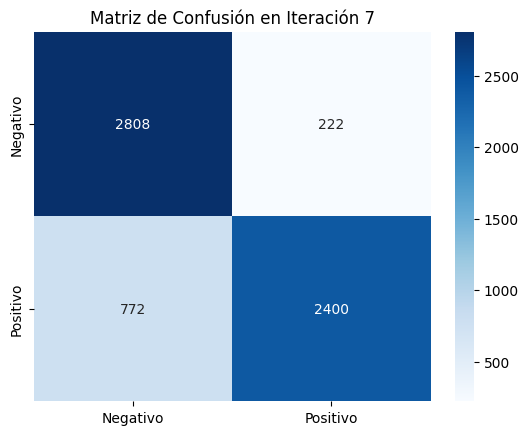

[I 2024-12-06 00:22:07,182] Trial 7 finished with value: 0.8284432171211599 and parameters: {'n_estimators': 308, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 8: 0.7528635890315862


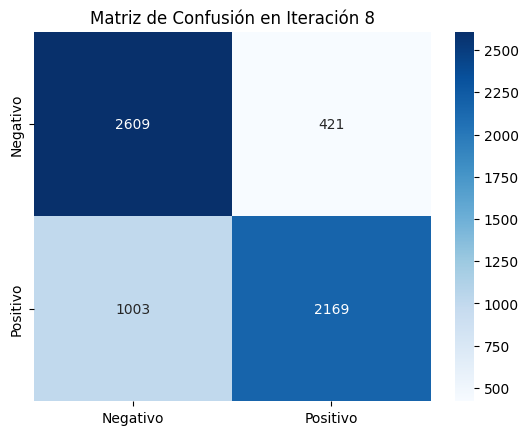

[I 2024-12-06 00:22:12,173] Trial 8 finished with value: 0.7528635890315862 and parameters: {'n_estimators': 497, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 9: 0.8470869639501111


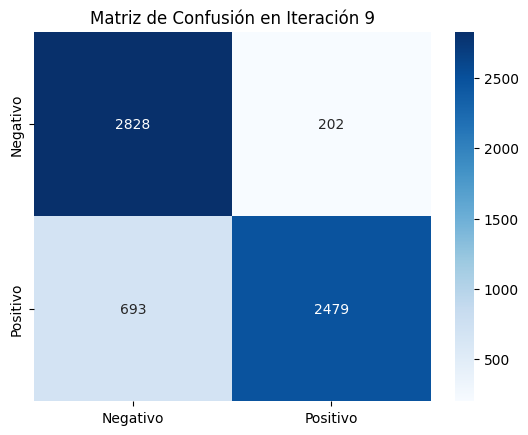

[I 2024-12-06 00:23:17,676] Trial 9 finished with value: 0.8470869639501111 and parameters: {'n_estimators': 319, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 9 with value: 0.8470869639501111.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 10: 0.8702264837163167


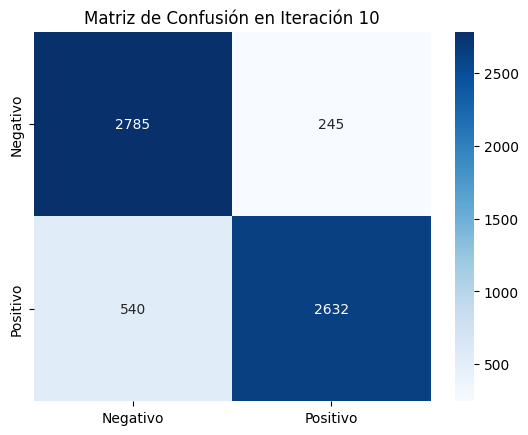

[I 2024-12-06 00:24:46,182] Trial 10 finished with value: 0.8702264837163167 and parameters: {'n_estimators': 368, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 10 with value: 0.8702264837163167.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 11: 0.8695077634621737


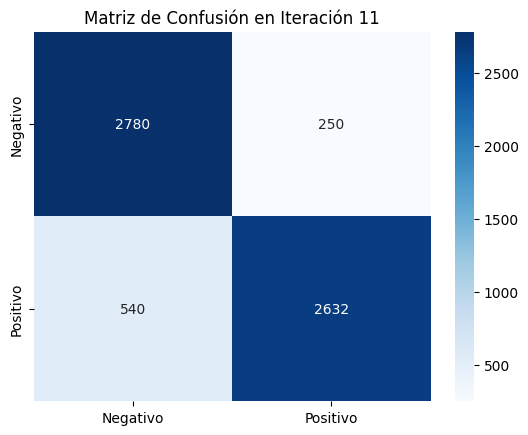

[I 2024-12-06 00:26:30,250] Trial 11 finished with value: 0.8695077634621737 and parameters: {'n_estimators': 377, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 10 with value: 0.8702264837163167.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 12: 0.8704132231404959


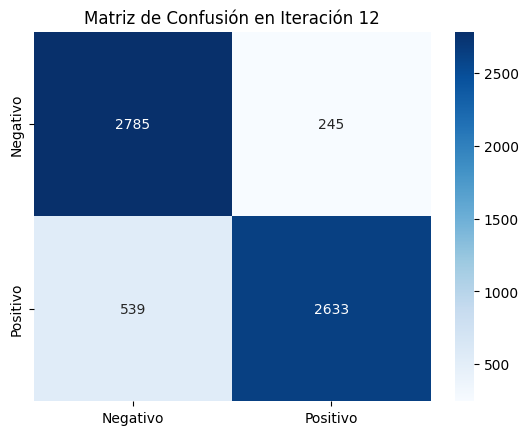

[I 2024-12-06 00:28:21,245] Trial 12 finished with value: 0.8704132231404959 and parameters: {'n_estimators': 391, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 13: 0.8568565224653416


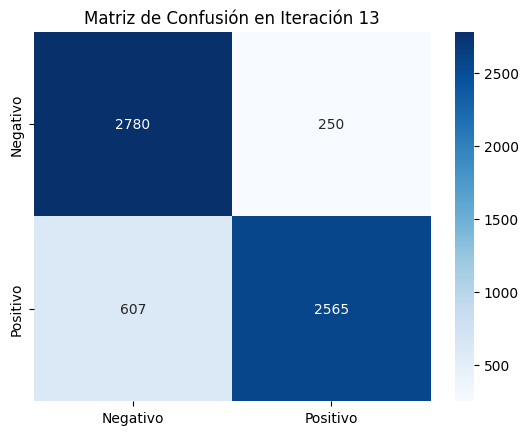

[I 2024-12-06 00:30:03,531] Trial 13 finished with value: 0.8568565224653416 and parameters: {'n_estimators': 405, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 14: 0.8666555685034126


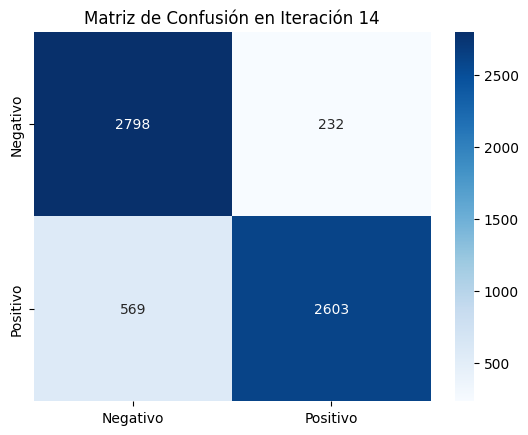

[I 2024-12-06 00:32:01,256] Trial 14 finished with value: 0.8666555685034126 and parameters: {'n_estimators': 427, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 15: 0.847252562594522


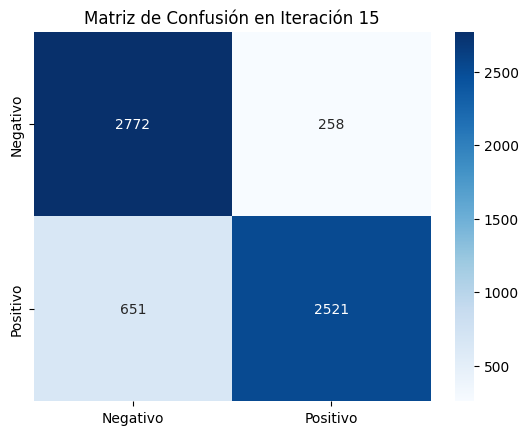

[I 2024-12-06 00:32:59,591] Trial 15 finished with value: 0.847252562594522 and parameters: {'n_estimators': 228, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 16: 0.8606242697379403


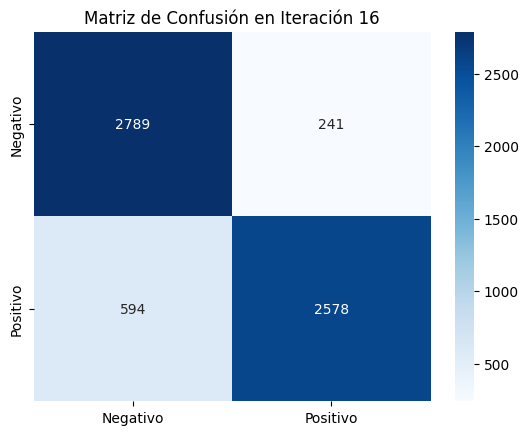

[I 2024-12-06 00:34:32,313] Trial 16 finished with value: 0.8606242697379403 and parameters: {'n_estimators': 342, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 17: 0.8241397198685804


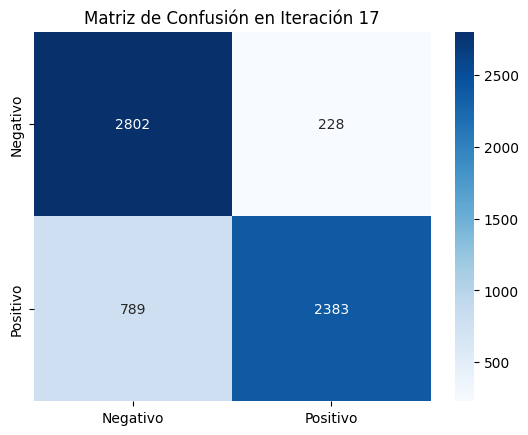

[I 2024-12-06 00:35:15,718] Trial 17 finished with value: 0.8241397198685804 and parameters: {'n_estimators': 230, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 18: 0.8678559629996696


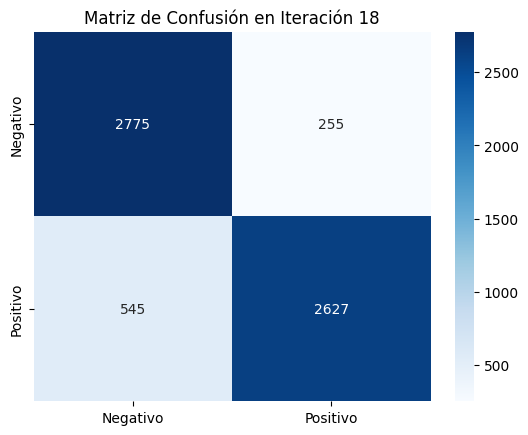

[I 2024-12-06 00:37:04,091] Trial 18 finished with value: 0.8678559629996696 and parameters: {'n_estimators': 450, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 19: 0.8496420047732697


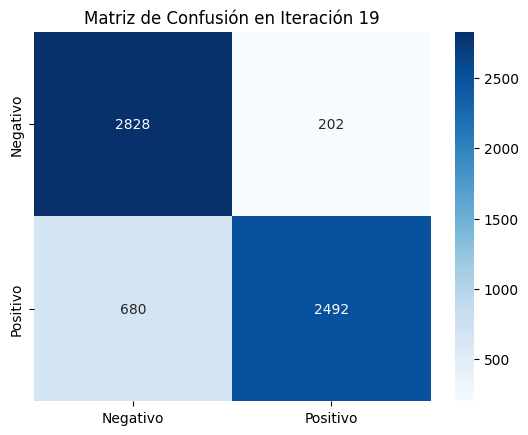

[I 2024-12-06 00:37:16,928] Trial 19 finished with value: 0.8496420047732697 and parameters: {'n_estimators': 359, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 20: 0.8420153714773698


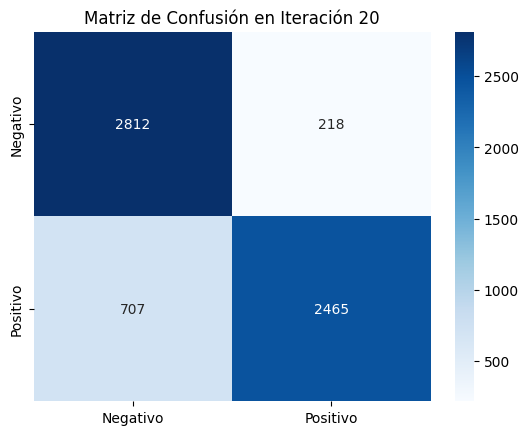

[I 2024-12-06 00:38:00,030] Trial 20 finished with value: 0.8420153714773698 and parameters: {'n_estimators': 232, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 21: 0.869364161849711


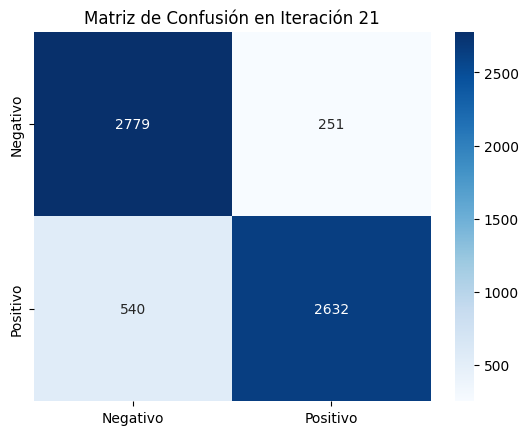

[I 2024-12-06 00:39:36,052] Trial 21 finished with value: 0.869364161849711 and parameters: {'n_estimators': 373, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 22: 0.8711331679073615


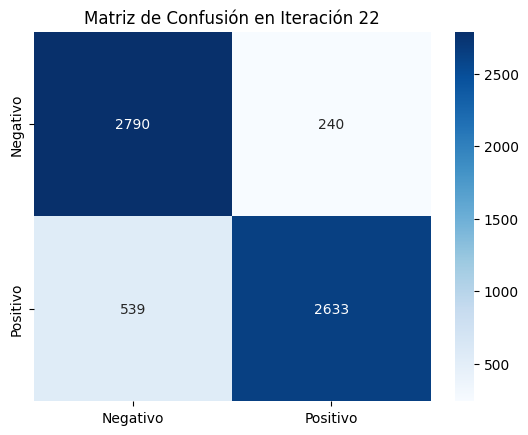

[I 2024-12-06 00:41:14,780] Trial 22 finished with value: 0.8711331679073615 and parameters: {'n_estimators': 384, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 23: 0.8615692153923038


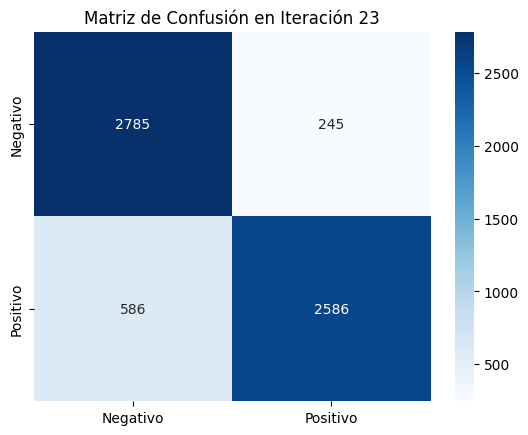

[I 2024-12-06 00:42:56,317] Trial 23 finished with value: 0.8615692153923038 and parameters: {'n_estimators': 443, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 24: 0.8629611083291604


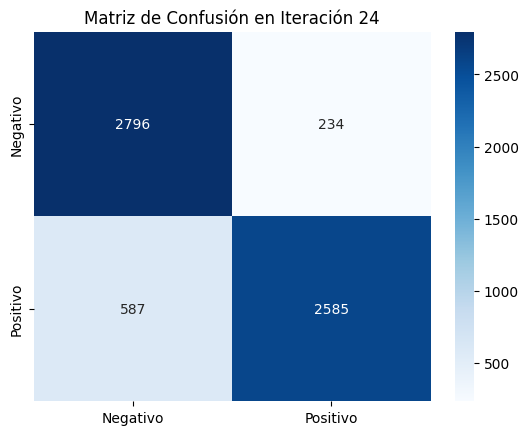

[I 2024-12-06 00:44:18,016] Trial 24 finished with value: 0.8629611083291604 and parameters: {'n_estimators': 337, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 25: 0.8669328010645376


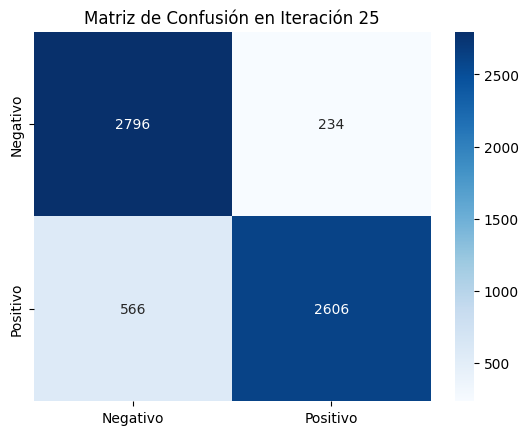

[I 2024-12-06 00:45:23,573] Trial 25 finished with value: 0.8669328010645376 and parameters: {'n_estimators': 265, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 26: 0.8665781613010288


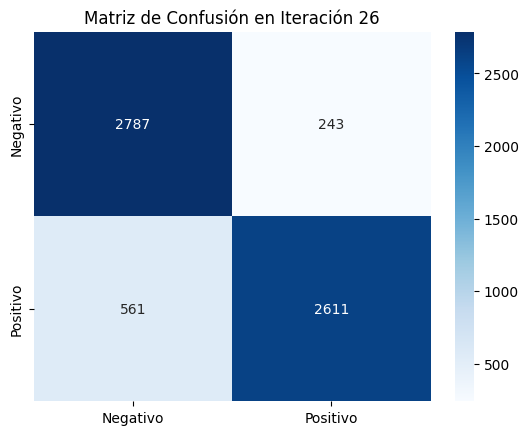

[I 2024-12-06 00:47:02,319] Trial 26 finished with value: 0.8665781613010288 and parameters: {'n_estimators': 426, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 27: 0.8540997464074387


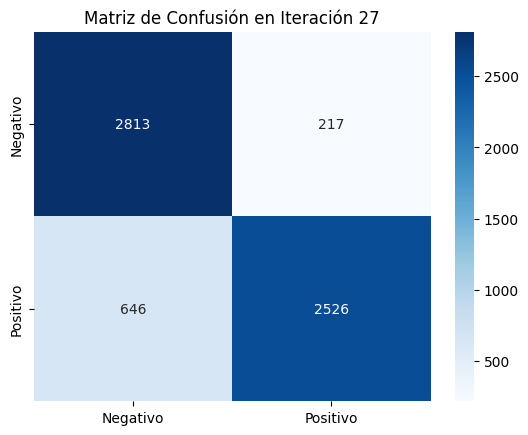

[I 2024-12-06 00:48:27,645] Trial 27 finished with value: 0.8540997464074387 and parameters: {'n_estimators': 388, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 28: 0.8671281445213574


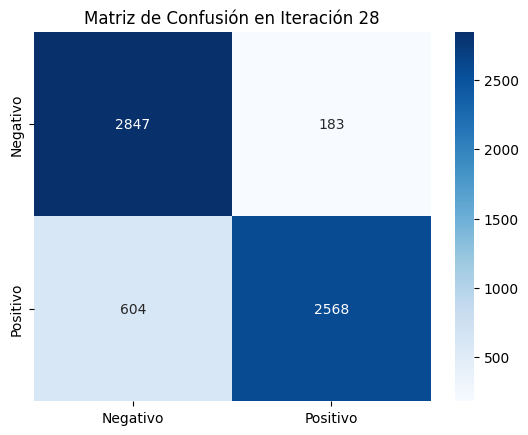

[I 2024-12-06 00:48:41,730] Trial 28 finished with value: 0.8671281445213574 and parameters: {'n_estimators': 273, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 29: 0.8514275944605916


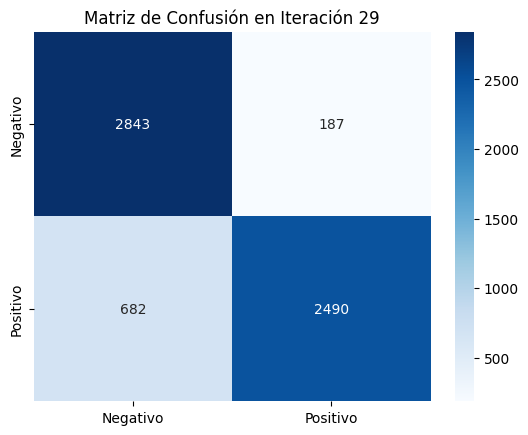

[I 2024-12-06 00:49:03,130] Trial 29 finished with value: 0.8514275944605916 and parameters: {'n_estimators': 460, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 30: 0.8303311031051638


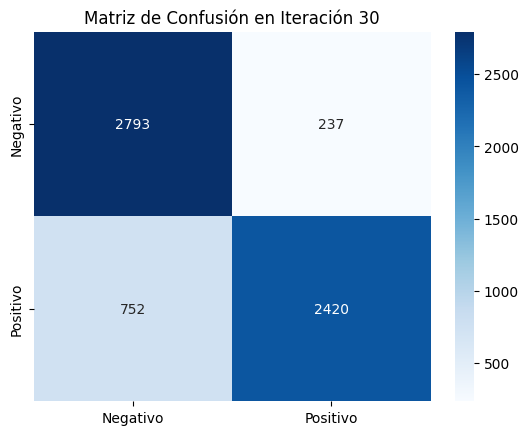

[I 2024-12-06 00:49:16,604] Trial 30 finished with value: 0.8303311031051638 and parameters: {'n_estimators': 350, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 31: 0.869220607661823


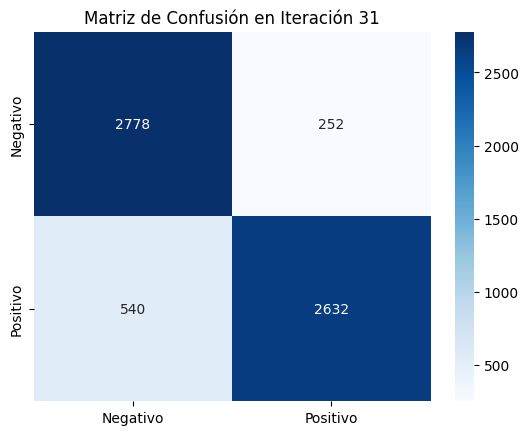

[I 2024-12-06 00:51:07,764] Trial 31 finished with value: 0.869220607661823 and parameters: {'n_estimators': 407, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 32: 0.8698811096433289


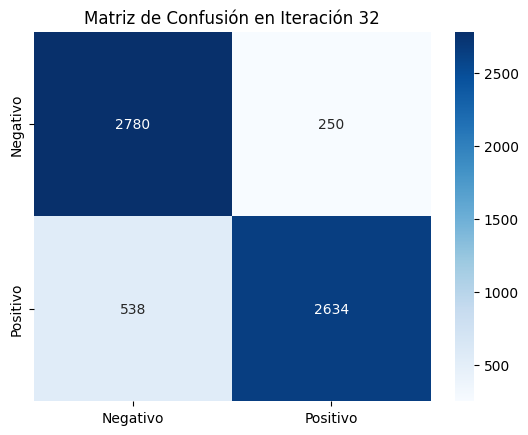

[I 2024-12-06 00:52:58,405] Trial 32 finished with value: 0.8698811096433289 and parameters: {'n_estimators': 376, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 33: 0.8662462661798872


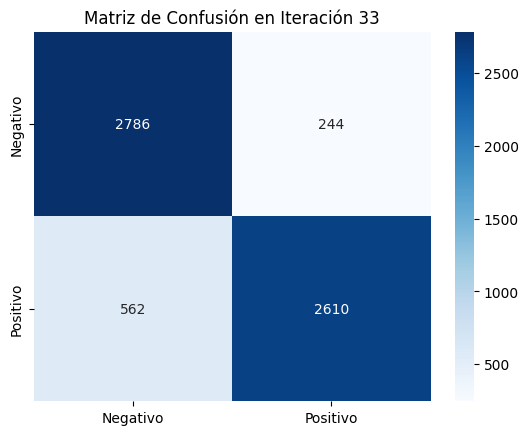

[I 2024-12-06 00:54:58,927] Trial 33 finished with value: 0.8662462661798872 and parameters: {'n_estimators': 489, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 34: 0.8632949424136205


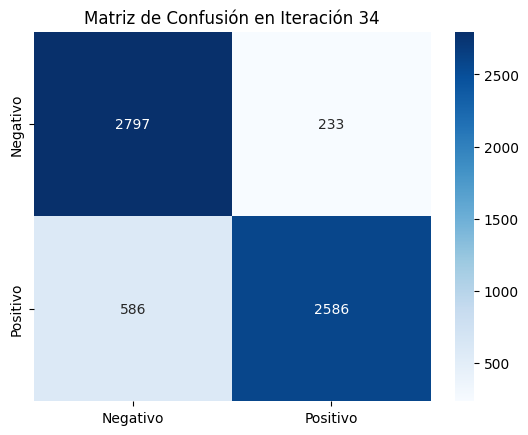

[I 2024-12-06 00:56:14,672] Trial 34 finished with value: 0.8632949424136205 and parameters: {'n_estimators': 317, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 35: 0.8349982776438167


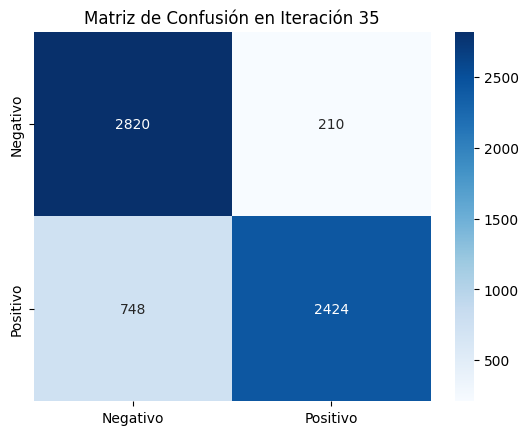

[I 2024-12-06 00:57:24,317] Trial 35 finished with value: 0.8349982776438167 and parameters: {'n_estimators': 427, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 36: 0.8604923798358733


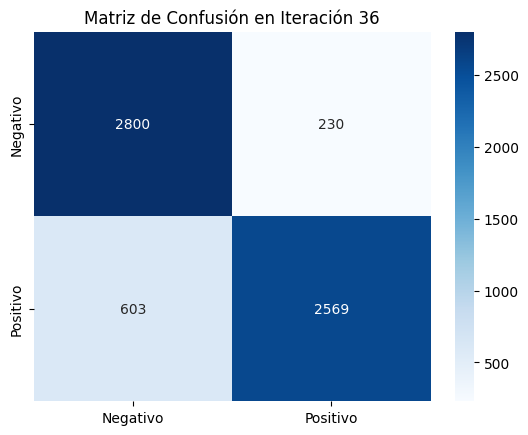

[I 2024-12-06 00:57:36,151] Trial 36 finished with value: 0.8604923798358733 and parameters: {'n_estimators': 53, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 37: 0.871081307627829


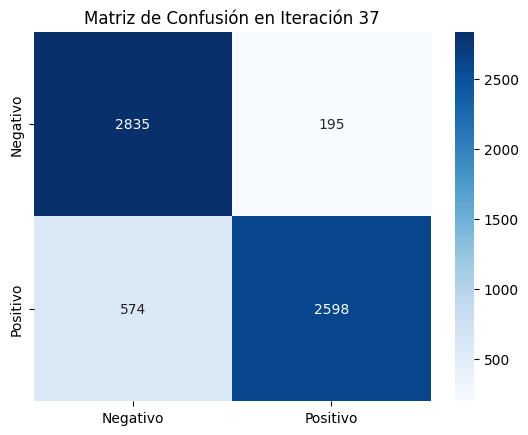

[I 2024-12-06 00:57:53,299] Trial 37 finished with value: 0.871081307627829 and parameters: {'n_estimators': 471, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 38: 0.8453890983887555


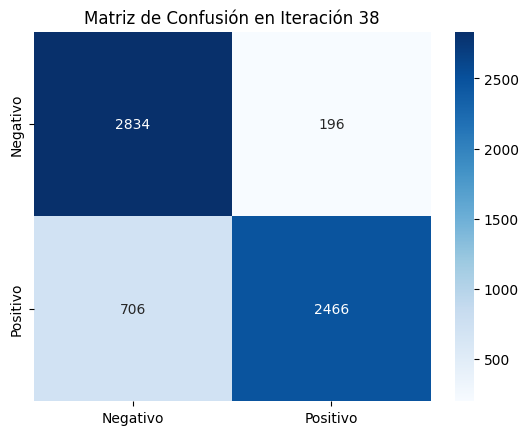

[I 2024-12-06 00:58:06,904] Trial 38 finished with value: 0.8453890983887555 and parameters: {'n_estimators': 476, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 39: 0.7725291964441345


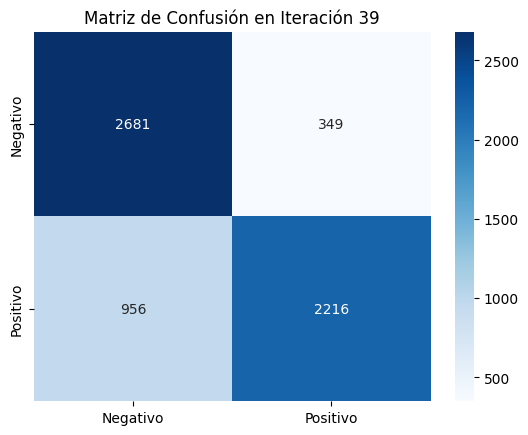

[I 2024-12-06 00:58:08,723] Trial 39 finished with value: 0.7725291964441345 and parameters: {'n_estimators': 94, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 40: 0.8204510242726804


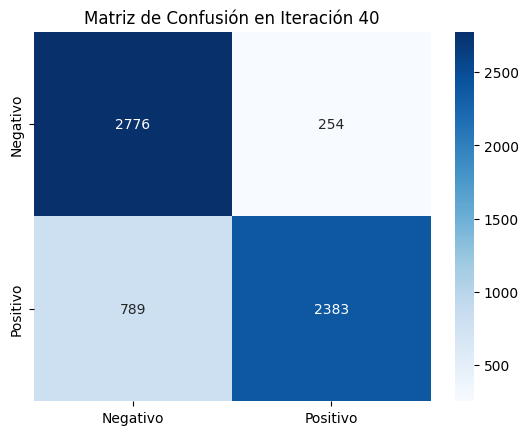

[I 2024-12-06 00:58:21,010] Trial 40 finished with value: 0.8204510242726804 and parameters: {'n_estimators': 464, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 41: 0.870670905136356


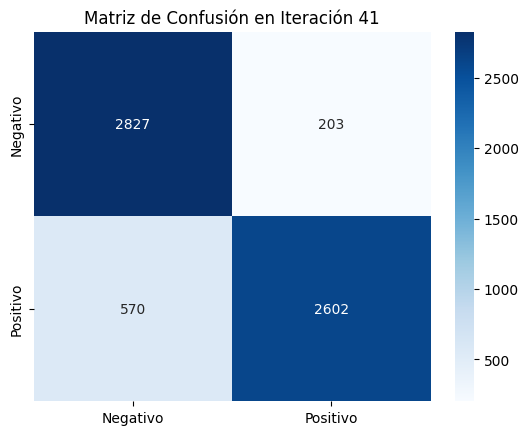

[I 2024-12-06 00:58:48,348] Trial 41 finished with value: 0.870670905136356 and parameters: {'n_estimators': 367, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 42: 0.8694779116465864


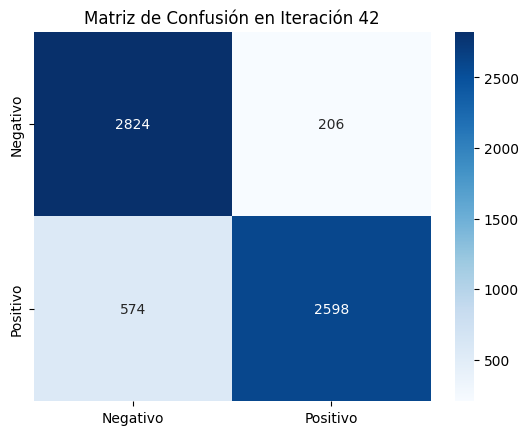

[I 2024-12-06 00:59:21,287] Trial 42 finished with value: 0.8694779116465864 and parameters: {'n_estimators': 405, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 43: 0.8691714189869172


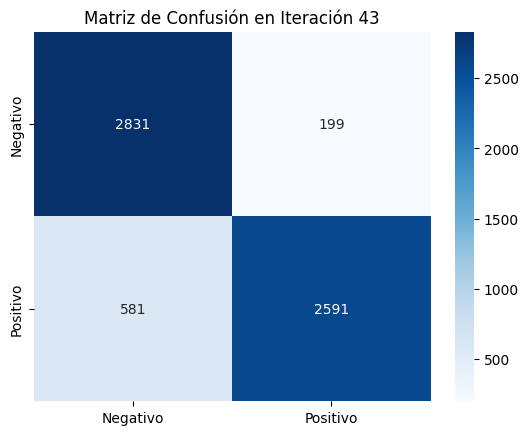

[I 2024-12-06 00:59:44,643] Trial 43 finished with value: 0.8691714189869172 and parameters: {'n_estimators': 303, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 44: 0.8545640326975477


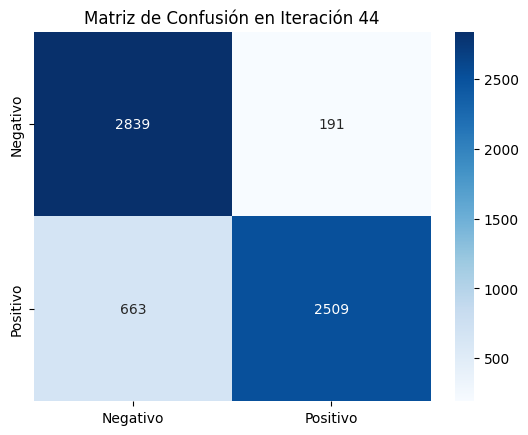

[I 2024-12-06 01:00:06,396] Trial 44 finished with value: 0.8545640326975477 and parameters: {'n_estimators': 329, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 45: 0.8584490348797833


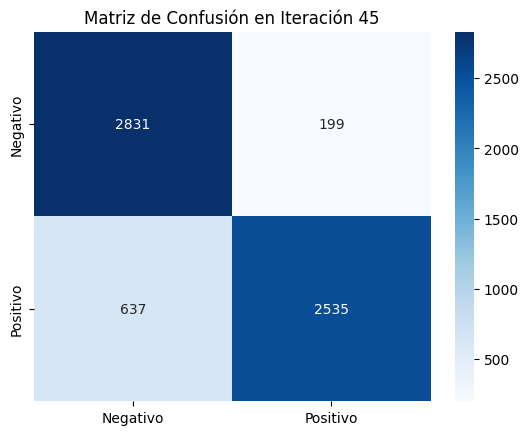

[I 2024-12-06 01:00:29,865] Trial 45 finished with value: 0.8584490348797833 and parameters: {'n_estimators': 358, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 46: 0.7616077616077616


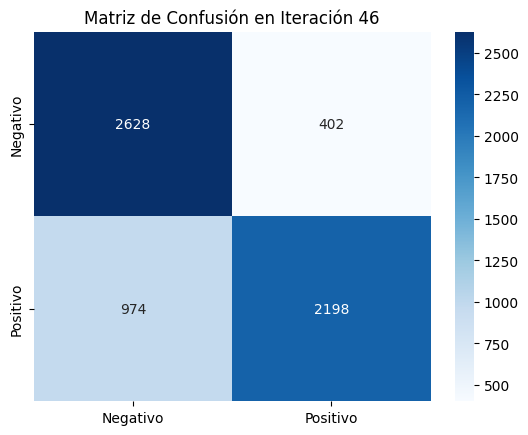

[I 2024-12-06 01:00:38,591] Trial 46 finished with value: 0.7616077616077616 and parameters: {'n_estimators': 391, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 47: 0.8517006802721089


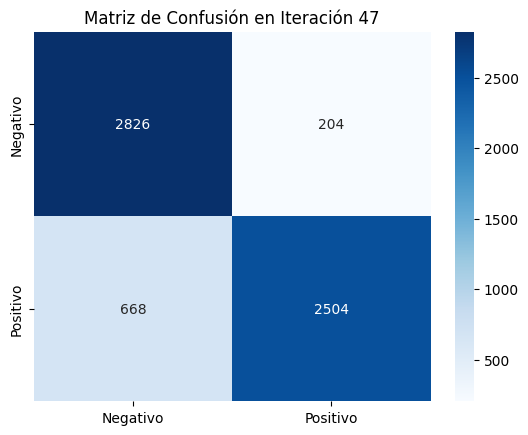

[I 2024-12-06 01:01:08,337] Trial 47 finished with value: 0.8517006802721089 and parameters: {'n_estimators': 424, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 48: 0.7422037422037422


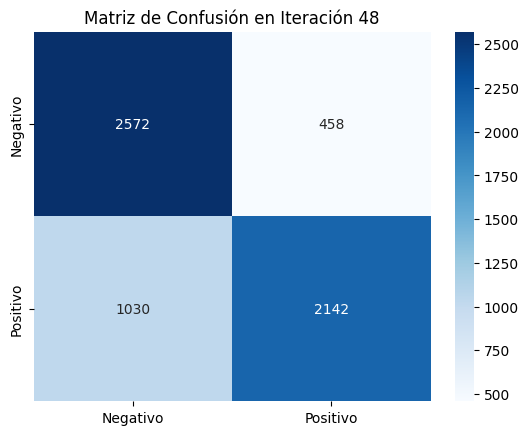

[I 2024-12-06 01:01:15,869] Trial 48 finished with value: 0.7422037422037422 and parameters: {'n_estimators': 441, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 49: 0.8366080661840745


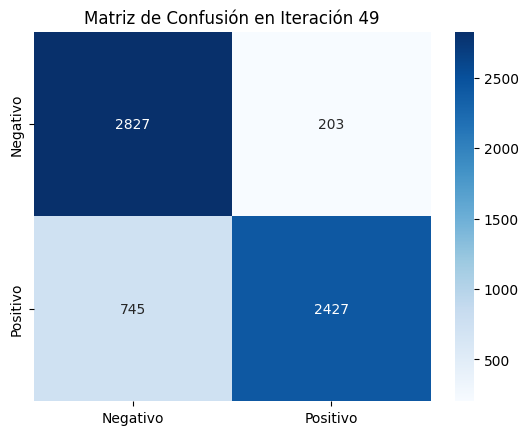

[I 2024-12-06 01:01:31,235] Trial 49 finished with value: 0.8366080661840745 and parameters: {'n_estimators': 293, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 22 with value: 0.8711331679073615.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mejores parámetros encontrados: {'n_estimators': 384, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}
Rendimiento final (F1) en X_test: 0.8644119907763259


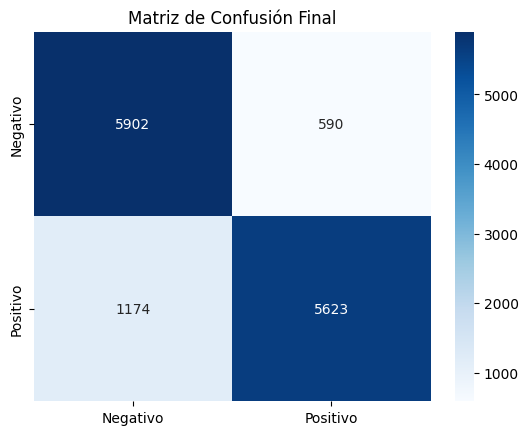

['final_pipeline.pkl']

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna


# Definir las columnas
ys = ['target']
binary_columns = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
id_columns = ['borrow_block_number']
wallet = ['wallet_address']
time_columns = [
    'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
    'time_since_first_deposit', 'time_since_last_liquidated','borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']

# Columnas a escalar
columns_to_scale = list(X0.columns.difference(id_columns + binary_columns + time_columns + ys + wallet))

# Preprocesador para escalar las columnas necesarias y pasar a través las demás
preprocessor = ColumnTransformer(
    transformers=[ 
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', id_columns + binary_columns + time_columns)
    ]
)

# Dividir en conjunto de entrenamiento (train) y conjunto de prueba (test)
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0, random_state=17)

# Ahora, dividir el conjunto de entrenamiento (X_train, y_train) en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=17)

y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

# Verificar tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

# Función para crear el pipeline con parámetros configurables
def create_pipeline(model):
    return Pipeline([
        ('preprocessing', preprocessor),  # Preprocesamiento
        ('model', model)  # Modelo
    ])

# Modelo inicial
initial_model = ExtraTreesClassifier(random_state=123)
initial_pipeline = create_pipeline(initial_model)

#X_train = X_train.to_numpy()
#y_train = y_train.to_numpy()
print(y_train)

# Entrenar el modelo inicial sin optimización de parámetros
initial_pipeline.fit(X_train, y_train)

# Evaluación inicial en el conjunto de test
initial_y_pred = initial_pipeline.predict(X_test)
initial_f1 = f1_score(y_test, initial_y_pred)
print(f'Rendimiento inicial (F1) en X_test: {initial_f1}')

# Crear la función objetivo para Optuna
def objective(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    #max_features=trial.choice(['sqrt', 'log2', None, 0.5, 0.8])
    
    # Definir el modelo ExtraTreesClassifier con los hiperparámetros sugeridos
    model = ExtraTreesClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=123)
    
    # Crear el pipeline
    pipeline = create_pipeline(model)
    
    # Entrenar el modelo
    pipeline.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de validación
    y_pred = pipeline.predict(X_val)
    
    # Calcular F1 score en el conjunto de validación
    f1 = f1_score(y_val, y_pred)
    
    # Mostrar el rendimiento durante cada iteración
    print(f'F1 score en iteración {trial.number}: {f1}')
    
    # Mostrar matriz de confusión durante cada iteración
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.title(f'Matriz de Confusión en Iteración {trial.number}')
    plt.show()

    return f1  # Queremos maximizar F1

# Configurar y ejecutar el estudio Optuna
study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=50)  

# Mejor conjunto de parámetros encontrados
best_params = study.best_params
print(f'Mejores parámetros encontrados: {best_params}')

# Crear el modelo final con los mejores parámetros
final_model = ExtraTreesClassifier(**best_params, random_state=123)

# Crear el pipeline final con el preprocesador
final_pipeline = create_pipeline(final_model)

# Entrenar el modelo final
final_pipeline.fit(X_train, y_train)

# Guardar el escalador (transformador) para uso posterior
joblib.dump(final_pipeline.named_steps['preprocessing'], 'scaler.pkl')

# Evaluación final en el conjunto de test con la métrica F1
final_y_pred = final_pipeline.predict(X_test)
final_f1 = f1_score(y_test, final_y_pred)
print(f'Rendimiento final (F1) en X_test: {final_f1}')

# Mostrar la matriz de confusión final
final_cm = confusion_matrix(y_test, final_y_pred)
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión Final')
plt.show()

# Guardar el pipeline final para uso posterior
joblib.dump(final_pipeline, 'final_pipeline.pkl')

[I 2024-12-06 01:43:22,914] A new study created in memory with name: no-name-13dfc48a-5219-42d4-b41c-2c6de158f753
[I 2024-12-06 01:43:55,610] Trial 0 finished with value: 0.8404709094011261 and parameters: {'n_estimators': 172, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 0 with value: 0.8404709094011261.


F1 score en iteración 0: 0.8404709094011261, AUC-PR: 0.9389653191851179


[I 2024-12-06 01:44:39,128] Trial 1 finished with value: 0.8176144244105409 and parameters: {'n_estimators': 249, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 0 with value: 0.8404709094011261.


F1 score en iteración 1: 0.8176144244105409, AUC-PR: 0.9259905149214523


[I 2024-12-06 01:44:46,214] Trial 2 finished with value: 0.8408664506225482 and parameters: {'n_estimators': 216, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.8408664506225482.


F1 score en iteración 2: 0.8408664506225482, AUC-PR: 0.9400052477346605


[I 2024-12-06 01:44:52,614] Trial 3 finished with value: 0.7654192654192654 and parameters: {'n_estimators': 272, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8408664506225482.


F1 score en iteración 3: 0.7654192654192654, AUC-PR: 0.8859770534489597


[I 2024-12-06 01:45:39,904] Trial 4 finished with value: 0.8290495083663965 and parameters: {'n_estimators': 259, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 2 with value: 0.8408664506225482.


F1 score en iteración 4: 0.8290495083663965, AUC-PR: 0.9329227526377046


[I 2024-12-06 01:45:43,140] Trial 5 finished with value: 0.7971665514858327 and parameters: {'n_estimators': 173, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.8408664506225482.


F1 score en iteración 5: 0.7971665514858327, AUC-PR: 0.9089745889118152


[I 2024-12-06 01:45:49,389] Trial 6 finished with value: 0.7845781466113416 and parameters: {'n_estimators': 281, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.8408664506225482.


F1 score en iteración 6: 0.7845781466113416, AUC-PR: 0.900987095254185


[I 2024-12-06 01:45:56,483] Trial 7 finished with value: 0.8177594217862674 and parameters: {'n_estimators': 228, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 2 with value: 0.8408664506225482.


F1 score en iteración 7: 0.8177594217862674, AUC-PR: 0.9234655591632934


[I 2024-12-06 01:46:00,543] Trial 8 finished with value: 0.8357695614789338 and parameters: {'n_estimators': 146, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.8408664506225482.


F1 score en iteración 8: 0.8357695614789338, AUC-PR: 0.9358846078620224


[I 2024-12-06 01:46:12,983] Trial 9 finished with value: 0.8342798141455859 and parameters: {'n_estimators': 261, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8408664506225482.


F1 score en iteración 9: 0.8342798141455859, AUC-PR: 0.9374043933687355


[I 2024-12-06 01:46:17,721] Trial 10 finished with value: 0.8592642591967601 and parameters: {'n_estimators': 101, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 10 with value: 0.8592642591967601.


F1 score en iteración 10: 0.8592642591967601, AUC-PR: 0.9495564953861857


[I 2024-12-06 01:46:22,068] Trial 11 finished with value: 0.8583488097248017 and parameters: {'n_estimators': 105, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 10 with value: 0.8592642591967601.


F1 score en iteración 11: 0.8583488097248017, AUC-PR: 0.9495184383326666


[I 2024-12-06 01:46:26,706] Trial 12 finished with value: 0.86098956580276 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 12 with value: 0.86098956580276.


F1 score en iteración 12: 0.86098956580276, AUC-PR: 0.9489756317537227


[I 2024-12-06 01:46:31,709] Trial 13 finished with value: 0.857916102841678 and parameters: {'n_estimators': 110, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 12 with value: 0.86098956580276.


F1 score en iteración 13: 0.857916102841678, AUC-PR: 0.9470173030681522


[I 2024-12-06 01:46:36,359] Trial 14 finished with value: 0.8469266133151712 and parameters: {'n_estimators': 132, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 12 with value: 0.86098956580276.


F1 score en iteración 14: 0.8469266133151712, AUC-PR: 0.9415081680736994


[I 2024-12-06 01:46:42,929] Trial 15 finished with value: 0.8613978676595024 and parameters: {'n_estimators': 143, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.8613978676595024.


F1 score en iteración 15: 0.8613978676595024, AUC-PR: 0.9503557147556365


[I 2024-12-06 01:46:49,118] Trial 16 finished with value: 0.8491048593350383 and parameters: {'n_estimators': 139, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.8613978676595024.


F1 score en iteración 16: 0.8491048593350383, AUC-PR: 0.9445630614749354


[I 2024-12-06 01:46:57,736] Trial 17 finished with value: 0.8484228473998295 and parameters: {'n_estimators': 173, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.8613978676595024.


F1 score en iteración 17: 0.8484228473998295, AUC-PR: 0.9438057734296119


[I 2024-12-06 01:47:02,674] Trial 18 finished with value: 0.8402931651610704 and parameters: {'n_estimators': 127, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.8613978676595024.


F1 score en iteración 18: 0.8402931651610704, AUC-PR: 0.9389705494066725


[I 2024-12-06 01:47:08,221] Trial 19 finished with value: 0.8470467736428815 and parameters: {'n_estimators': 159, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.8613978676595024.


F1 score en iteración 19: 0.8470467736428815, AUC-PR: 0.9434343686572435


[I 2024-12-06 01:47:14,012] Trial 20 finished with value: 0.8210851648351648 and parameters: {'n_estimators': 186, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.8613978676595024.


F1 score en iteración 20: 0.8210851648351648, AUC-PR: 0.9274588775174876


[I 2024-12-06 01:47:17,523] Trial 21 finished with value: 0.8607509681764607 and parameters: {'n_estimators': 101, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 15 with value: 0.8613978676595024.


F1 score en iteración 21: 0.8607509681764607, AUC-PR: 0.9489675755856019


[I 2024-12-06 01:47:22,862] Trial 22 finished with value: 0.8660834454912517 and parameters: {'n_estimators': 121, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 22 with value: 0.8660834454912517.


F1 score en iteración 22: 0.8660834454912517, AUC-PR: 0.9525750933073608


[I 2024-12-06 01:47:53,961] Trial 23 finished with value: 0.8676616915422886 and parameters: {'n_estimators': 122, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 23: 0.8676616915422886, AUC-PR: 0.9520924028595721


[I 2024-12-06 01:48:26,545] Trial 24 finished with value: 0.8637421070122965 and parameters: {'n_estimators': 125, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 24: 0.8637421070122965, AUC-PR: 0.9515424079929306


[I 2024-12-06 01:48:56,798] Trial 25 finished with value: 0.8675178245730393 and parameters: {'n_estimators': 125, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 25: 0.8675178245730393, AUC-PR: 0.9520860286238791


[I 2024-12-06 01:49:35,803] Trial 26 finished with value: 0.8521885521885522 and parameters: {'n_estimators': 199, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 26: 0.8521885521885522, AUC-PR: 0.9469381582489685


[I 2024-12-06 01:50:00,808] Trial 27 finished with value: 0.8590021691973969 and parameters: {'n_estimators': 116, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 27: 0.8590021691973969, AUC-PR: 0.9497592960865622


[I 2024-12-06 01:50:27,674] Trial 28 finished with value: 0.8420514568069518 and parameters: {'n_estimators': 154, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 28: 0.8420514568069518, AUC-PR: 0.9404009480234717


[I 2024-12-06 01:50:53,535] Trial 29 finished with value: 0.858100184285475 and parameters: {'n_estimators': 119, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 29: 0.858100184285475, AUC-PR: 0.9489800724309659


[I 2024-12-06 01:51:28,105] Trial 30 finished with value: 0.8633716092527874 and parameters: {'n_estimators': 159, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 30: 0.8633716092527874, AUC-PR: 0.9514978296815372


[I 2024-12-06 01:51:57,968] Trial 31 finished with value: 0.8670865097779251 and parameters: {'n_estimators': 127, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 31: 0.8670865097779251, AUC-PR: 0.952052274492685


[I 2024-12-06 01:53:56,658] Trial 32 finished with value: 0.8653399668325041 and parameters: {'n_estimators': 299, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 32: 0.8653399668325041, AUC-PR: 0.9518799355935879


[I 2024-12-06 01:54:57,347] Trial 33 finished with value: 0.8563333333333333 and parameters: {'n_estimators': 134, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 33: 0.8563333333333333, AUC-PR: 0.9478359907936322


[I 2024-12-06 01:56:00,647] Trial 34 finished with value: 0.8608521970705726 and parameters: {'n_estimators': 118, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 34: 0.8608521970705726, AUC-PR: 0.949915266885314


[I 2024-12-06 01:57:14,433] Trial 35 finished with value: 0.8595758891300718 and parameters: {'n_estimators': 149, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 35: 0.8595758891300718, AUC-PR: 0.9489043122270313


[I 2024-12-06 01:59:02,011] Trial 36 finished with value: 0.8510139098374393 and parameters: {'n_estimators': 228, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 36: 0.8510139098374393, AUC-PR: 0.9447204335262703


[I 2024-12-06 02:00:22,915] Trial 37 finished with value: 0.8570951027912419 and parameters: {'n_estimators': 165, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 37: 0.8570951027912419, AUC-PR: 0.9477216387578444


[I 2024-12-06 02:01:18,501] Trial 38 finished with value: 0.8202090592334494 and parameters: {'n_estimators': 181, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 38: 0.8202090592334494, AUC-PR: 0.9256410888488591


[I 2024-12-06 02:02:06,728] Trial 39 finished with value: 0.8334765423612305 and parameters: {'n_estimators': 126, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 39: 0.8334765423612305, AUC-PR: 0.9362295007957815


[I 2024-12-06 02:03:06,749] Trial 40 finished with value: 0.834074580910024 and parameters: {'n_estimators': 141, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 40: 0.834074580910024, AUC-PR: 0.9372592973017928


[I 2024-12-06 02:05:37,950] Trial 41 finished with value: 0.8646853727378383 and parameters: {'n_estimators': 292, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 41: 0.8646853727378383, AUC-PR: 0.9518259031219086


[I 2024-12-06 02:07:36,126] Trial 42 finished with value: 0.8653686137460476 and parameters: {'n_estimators': 227, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 42: 0.8653686137460476, AUC-PR: 0.951813877756618


[I 2024-12-06 02:09:40,181] Trial 43 finished with value: 0.8652224243426493 and parameters: {'n_estimators': 232, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 43: 0.8652224243426493, AUC-PR: 0.9520535737545475


[I 2024-12-06 02:11:14,071] Trial 44 finished with value: 0.8668442077230359 and parameters: {'n_estimators': 209, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 44: 0.8668442077230359, AUC-PR: 0.9527039584383322


[I 2024-12-06 02:11:21,107] Trial 45 finished with value: 0.8554401498382428 and parameters: {'n_estimators': 208, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 45: 0.8554401498382428, AUC-PR: 0.9475832133476131


[I 2024-12-06 02:12:04,076] Trial 46 finished with value: 0.8607040592892033 and parameters: {'n_estimators': 196, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 46: 0.8607040592892033, AUC-PR: 0.9512260813668104


[I 2024-12-06 02:12:08,182] Trial 47 finished with value: 0.863973063973064 and parameters: {'n_estimators': 112, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 47: 0.863973063973064, AUC-PR: 0.9510498927885839


[I 2024-12-06 02:12:45,983] Trial 48 finished with value: 0.8348327957901884 and parameters: {'n_estimators': 210, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 48: 0.8348327957901884, AUC-PR: 0.9360774502293902


[I 2024-12-06 02:12:52,924] Trial 49 finished with value: 0.8396711202466598 and parameters: {'n_estimators': 237, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 23 with value: 0.8676616915422886.


F1 score en iteración 49: 0.8396711202466598, AUC-PR: 0.9400649127285636


[I 2024-12-06 02:13:24,863] Trial 50 finished with value: 0.869550858652576 and parameters: {'n_estimators': 134, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 50 with value: 0.869550858652576.


F1 score en iteración 50: 0.869550858652576, AUC-PR: 0.9536774276126114


[I 2024-12-06 02:13:57,662] Trial 51 finished with value: 0.8698381235546746 and parameters: {'n_estimators': 136, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 51 with value: 0.8698381235546746.


F1 score en iteración 51: 0.8698381235546746, AUC-PR: 0.9536661109410155


[I 2024-12-06 02:14:29,545] Trial 52 finished with value: 0.8690338563170933 and parameters: {'n_estimators': 132, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 51 with value: 0.8698381235546746.


F1 score en iteración 52: 0.8690338563170933, AUC-PR: 0.9533789108078076


[I 2024-12-06 02:14:59,794] Trial 53 finished with value: 0.8637939574046558 and parameters: {'n_estimators': 133, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 51 with value: 0.8698381235546746.


F1 score en iteración 53: 0.8637939574046558, AUC-PR: 0.9514666787642889


[I 2024-12-06 02:15:33,295] Trial 54 finished with value: 0.8660684612828182 and parameters: {'n_estimators': 147, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 51 with value: 0.8698381235546746.


F1 score en iteración 54: 0.8660684612828182, AUC-PR: 0.9524963492702866


[I 2024-12-06 02:15:59,314] Trial 55 finished with value: 0.8672624958622972 and parameters: {'n_estimators': 109, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 51 with value: 0.8698381235546746.


F1 score en iteración 55: 0.8672624958622972, AUC-PR: 0.9529453570719268


[I 2024-12-06 02:16:25,632] Trial 56 finished with value: 0.8651685393258427 and parameters: {'n_estimators': 109, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 51 with value: 0.8698381235546746.


F1 score en iteración 56: 0.8651685393258427, AUC-PR: 0.953589039680774


[I 2024-12-06 02:16:58,542] Trial 57 finished with value: 0.8687902294107939 and parameters: {'n_estimators': 136, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 51 with value: 0.8698381235546746.


F1 score en iteración 57: 0.8687902294107939, AUC-PR: 0.9533603913845093


[I 2024-12-06 02:17:31,399] Trial 58 finished with value: 0.8687902294107939 and parameters: {'n_estimators': 136, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 51 with value: 0.8698381235546746.


F1 score en iteración 58: 0.8687902294107939, AUC-PR: 0.9533603913845093


[I 2024-12-06 02:18:11,731] Trial 59 finished with value: 0.8685035472694275 and parameters: {'n_estimators': 167, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 51 with value: 0.8698381235546746.


F1 score en iteración 59: 0.8685035472694275, AUC-PR: 0.9536233542759006


[I 2024-12-06 02:18:52,178] Trial 60 finished with value: 0.866765725606736 and parameters: {'n_estimators': 167, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 51 with value: 0.8698381235546746.


F1 score en iteración 60: 0.866765725606736, AUC-PR: 0.954393604124589


[I 2024-12-06 02:19:25,235] Trial 61 finished with value: 0.8703398218409766 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 61: 0.8703398218409766, AUC-PR: 0.9532642598980352


[I 2024-12-06 02:19:58,008] Trial 62 finished with value: 0.8703398218409766 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 62: 0.8703398218409766, AUC-PR: 0.9532642598980352


[I 2024-12-06 02:20:34,275] Trial 63 finished with value: 0.8684601419376135 and parameters: {'n_estimators': 152, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 63: 0.8684601419376135, AUC-PR: 0.9535010897757638


[I 2024-12-06 02:20:40,003] Trial 64 finished with value: 0.8677088586317028 and parameters: {'n_estimators': 137, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 64: 0.8677088586317028, AUC-PR: 0.9544479669060921


[I 2024-12-06 02:21:14,007] Trial 65 finished with value: 0.8698517298187809 and parameters: {'n_estimators': 141, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 65: 0.8698517298187809, AUC-PR: 0.9544792630639238


[I 2024-12-06 02:21:48,497] Trial 66 finished with value: 0.8692066633679697 and parameters: {'n_estimators': 143, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 66: 0.8692066633679697, AUC-PR: 0.9544769203594081


[I 2024-12-06 02:22:22,966] Trial 67 finished with value: 0.8687469044081229 and parameters: {'n_estimators': 145, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 67: 0.8687469044081229, AUC-PR: 0.9541962943700747


[I 2024-12-06 02:22:50,870] Trial 68 finished with value: 0.8378698224852071 and parameters: {'n_estimators': 155, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 68: 0.8378698224852071, AUC-PR: 0.9371541002785767


[I 2024-12-06 02:22:56,143] Trial 69 finished with value: 0.859126312224856 and parameters: {'n_estimators': 130, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 69: 0.859126312224856, AUC-PR: 0.9506561740930355


[I 2024-12-06 02:23:27,244] Trial 70 finished with value: 0.8617940199335549 and parameters: {'n_estimators': 143, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 70: 0.8617940199335549, AUC-PR: 0.9496478504177407


[I 2024-12-06 02:24:00,301] Trial 71 finished with value: 0.8691341705221415 and parameters: {'n_estimators': 139, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 71: 0.8691341705221415, AUC-PR: 0.9545790544196724


[I 2024-12-06 02:24:37,665] Trial 72 finished with value: 0.8685865607414763 and parameters: {'n_estimators': 157, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 72: 0.8685865607414763, AUC-PR: 0.9548938557070171


[I 2024-12-06 02:25:11,008] Trial 73 finished with value: 0.8678996036988111 and parameters: {'n_estimators': 141, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 73: 0.8678996036988111, AUC-PR: 0.9541404670031688


[I 2024-12-06 02:25:38,347] Trial 74 finished with value: 0.8490856263886515 and parameters: {'n_estimators': 149, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 61 with value: 0.8703398218409766.


F1 score en iteración 74: 0.8490856263886515, AUC-PR: 0.946175933584997


[I 2024-12-06 02:26:05,562] Trial 75 finished with value: 0.8710582796764075 and parameters: {'n_estimators': 114, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 75: 0.8710582796764075, AUC-PR: 0.9545777945791944


[I 2024-12-06 02:26:31,722] Trial 76 finished with value: 0.8661913447189521 and parameters: {'n_estimators': 117, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 76: 0.8661913447189521, AUC-PR: 0.952494677012772


[I 2024-12-06 02:26:56,175] Trial 77 finished with value: 0.86755731486063 and parameters: {'n_estimators': 104, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 77: 0.86755731486063, AUC-PR: 0.9530035575740717


[I 2024-12-06 02:27:36,366] Trial 78 finished with value: 0.8631753948462177 and parameters: {'n_estimators': 179, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 78: 0.8631753948462177, AUC-PR: 0.9527317715566113


[I 2024-12-06 02:28:09,630] Trial 79 finished with value: 0.8695652173913043 and parameters: {'n_estimators': 123, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 79: 0.8695652173913043, AUC-PR: 0.9546398500684541


[I 2024-12-06 02:28:38,126] Trial 80 finished with value: 0.8649006622516556 and parameters: {'n_estimators': 123, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 80: 0.8649006622516556, AUC-PR: 0.9529511228755203


[I 2024-12-06 02:29:09,129] Trial 81 finished with value: 0.8694646397884996 and parameters: {'n_estimators': 129, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 81: 0.8694646397884996, AUC-PR: 0.9546834687931337


[I 2024-12-06 02:29:36,377] Trial 82 finished with value: 0.8691203168839743 and parameters: {'n_estimators': 112, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 82: 0.8691203168839743, AUC-PR: 0.9530596592570785


[I 2024-12-06 02:30:07,510] Trial 83 finished with value: 0.8694646397884996 and parameters: {'n_estimators': 129, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 83: 0.8694646397884996, AUC-PR: 0.9546834687931337


[I 2024-12-06 02:30:37,745] Trial 84 finished with value: 0.8693200663349917 and parameters: {'n_estimators': 129, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 84: 0.8693200663349917, AUC-PR: 0.9536737398758841


[I 2024-12-06 02:31:06,498] Trial 85 finished with value: 0.8682813536828136 and parameters: {'n_estimators': 121, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 85: 0.8682813536828136, AUC-PR: 0.9533879671645146


[I 2024-12-06 02:31:11,122] Trial 86 finished with value: 0.8612941375232303 and parameters: {'n_estimators': 114, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 86: 0.8612941375232303, AUC-PR: 0.9498861746648918


[I 2024-12-06 02:31:31,529] Trial 87 finished with value: 0.8425675675675676 and parameters: {'n_estimators': 106, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 87: 0.8425675675675676, AUC-PR: 0.9411174390225193


[I 2024-12-06 02:32:10,105] Trial 88 finished with value: 0.8676130736216573 and parameters: {'n_estimators': 161, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 88: 0.8676130736216573, AUC-PR: 0.9534198027578129


[I 2024-12-06 02:32:38,780] Trial 89 finished with value: 0.8649186856953203 and parameters: {'n_estimators': 128, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 89: 0.8649186856953203, AUC-PR: 0.9528366625573949


[I 2024-12-06 02:33:03,175] Trial 90 finished with value: 0.8580590717299578 and parameters: {'n_estimators': 120, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 90: 0.8580590717299578, AUC-PR: 0.9495855329480072


[I 2024-12-06 02:33:33,420] Trial 91 finished with value: 0.8693200663349917 and parameters: {'n_estimators': 129, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 91: 0.8693200663349917, AUC-PR: 0.9536737398758841


[I 2024-12-06 02:34:02,518] Trial 92 finished with value: 0.8685126844636047 and parameters: {'n_estimators': 125, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 92: 0.8685126844636047, AUC-PR: 0.9530724876288901


[I 2024-12-06 02:34:34,913] Trial 93 finished with value: 0.8693069306930693 and parameters: {'n_estimators': 134, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 93: 0.8693069306930693, AUC-PR: 0.953329716004166


[I 2024-12-06 02:35:02,283] Trial 94 finished with value: 0.8690909090909091 and parameters: {'n_estimators': 117, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 94: 0.8690909090909091, AUC-PR: 0.9542256035443037


[I 2024-12-06 02:35:36,026] Trial 95 finished with value: 0.8645418326693227 and parameters: {'n_estimators': 150, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 95: 0.8645418326693227, AUC-PR: 0.952115210447173


[I 2024-12-06 02:35:55,643] Trial 96 finished with value: 0.832986832986833 and parameters: {'n_estimators': 131, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 96: 0.832986832986833, AUC-PR: 0.9368758370548357


[I 2024-12-06 02:36:05,104] Trial 97 finished with value: 0.8610970464135022 and parameters: {'n_estimators': 270, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 97: 0.8610970464135022, AUC-PR: 0.9498178744219835


[I 2024-12-06 02:36:34,668] Trial 98 finished with value: 0.8695079809116341 and parameters: {'n_estimators': 123, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 98: 0.8695079809116341, AUC-PR: 0.9547314849566467


[I 2024-12-06 02:37:02,601] Trial 99 finished with value: 0.8649006622516556 and parameters: {'n_estimators': 123, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 99: 0.8649006622516556, AUC-PR: 0.9529511228755203


[I 2024-12-06 02:37:25,799] Trial 100 finished with value: 0.8620232172470979 and parameters: {'n_estimators': 102, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 100: 0.8620232172470979, AUC-PR: 0.950674724890523


[I 2024-12-06 02:37:59,168] Trial 101 finished with value: 0.8690633245382586 and parameters: {'n_estimators': 139, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 101: 0.8690633245382586, AUC-PR: 0.9533978896028943


[I 2024-12-06 02:38:30,245] Trial 102 finished with value: 0.869780491830335 and parameters: {'n_estimators': 129, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 102: 0.869780491830335, AUC-PR: 0.953480254516822


[I 2024-12-06 02:38:58,165] Trial 103 finished with value: 0.8695222405271829 and parameters: {'n_estimators': 116, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 103: 0.8695222405271829, AUC-PR: 0.9545643966034484


[I 2024-12-06 02:39:26,073] Trial 104 finished with value: 0.8695222405271829 and parameters: {'n_estimators': 116, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 104: 0.8695222405271829, AUC-PR: 0.9545643966034484


[I 2024-12-06 02:39:52,465] Trial 105 finished with value: 0.8689768976897689 and parameters: {'n_estimators': 108, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 105: 0.8689768976897689, AUC-PR: 0.9544049694385196


[I 2024-12-06 02:40:18,169] Trial 106 finished with value: 0.8646951924665455 and parameters: {'n_estimators': 114, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 75 with value: 0.8710582796764075.


F1 score en iteración 106: 0.8646951924665455, AUC-PR: 0.95121442622281


[I 2024-12-06 02:40:23,466] Trial 107 finished with value: 0.8724787464577429 and parameters: {'n_estimators': 119, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 107 with value: 0.8724787464577429.


F1 score en iteración 107: 0.8724787464577429, AUC-PR: 0.9553846428035498


[I 2024-12-06 02:40:28,793] Trial 108 finished with value: 0.8720600500417014 and parameters: {'n_estimators': 117, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 107 with value: 0.8724787464577429.


F1 score en iteración 108: 0.8720600500417014, AUC-PR: 0.9552287471383413


[I 2024-12-06 02:40:32,210] Trial 109 finished with value: 0.8344733242134063 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 107 with value: 0.8724787464577429.


F1 score en iteración 109: 0.8344733242134063, AUC-PR: 0.9362654495851386


[I 2024-12-06 02:40:37,190] Trial 110 finished with value: 0.8681135225375626 and parameters: {'n_estimators': 111, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 107 with value: 0.8724787464577429.


F1 score en iteración 110: 0.8681135225375626, AUC-PR: 0.955018094299766


[I 2024-12-06 02:40:42,491] Trial 111 finished with value: 0.8729868836128175 and parameters: {'n_estimators': 118, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 111 with value: 0.8729868836128175.


F1 score en iteración 111: 0.8729868836128175, AUC-PR: 0.95655780509256


[I 2024-12-06 02:40:48,460] Trial 112 finished with value: 0.8678678678678678 and parameters: {'n_estimators': 134, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 111 with value: 0.8729868836128175.


F1 score en iteración 112: 0.8678678678678678, AUC-PR: 0.955347454500816


[I 2024-12-06 02:40:53,902] Trial 113 finished with value: 0.873234756604087 and parameters: {'n_estimators': 119, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 113: 0.873234756604087, AUC-PR: 0.9565732727516947


[I 2024-12-06 02:40:59,061] Trial 114 finished with value: 0.858922558922559 and parameters: {'n_estimators': 120, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 114: 0.858922558922559, AUC-PR: 0.9510706869789005


[I 2024-12-06 02:41:05,674] Trial 115 finished with value: 0.8701168614357262 and parameters: {'n_estimators': 146, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 115: 0.8701168614357262, AUC-PR: 0.9560872593206314


[I 2024-12-06 02:41:12,067] Trial 116 finished with value: 0.8701168614357262 and parameters: {'n_estimators': 146, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 116: 0.8701168614357262, AUC-PR: 0.9560872593206314


[I 2024-12-06 02:41:18,553] Trial 117 finished with value: 0.8704939919893191 and parameters: {'n_estimators': 145, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 117: 0.8704939919893191, AUC-PR: 0.9560715344052247


[I 2024-12-06 02:41:23,215] Trial 118 finished with value: 0.8265113889364617 and parameters: {'n_estimators': 145, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 118: 0.8265113889364617, AUC-PR: 0.929889726649527


[I 2024-12-06 02:41:29,544] Trial 119 finished with value: 0.8615643397813288 and parameters: {'n_estimators': 148, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 119: 0.8615643397813288, AUC-PR: 0.9513146784473355


[I 2024-12-06 02:41:34,036] Trial 120 finished with value: 0.8291509109659677 and parameters: {'n_estimators': 141, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 120: 0.8291509109659677, AUC-PR: 0.9333740578955603


[I 2024-12-06 02:41:40,230] Trial 121 finished with value: 0.8707256046705588 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 121: 0.8707256046705588, AUC-PR: 0.9560584649583533


[I 2024-12-06 02:41:47,203] Trial 122 finished with value: 0.8706550802139037 and parameters: {'n_estimators': 155, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 122: 0.8706550802139037, AUC-PR: 0.9561806101571018


[I 2024-12-06 02:41:54,168] Trial 123 finished with value: 0.8705528645398363 and parameters: {'n_estimators': 156, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 123: 0.8705528645398363, AUC-PR: 0.9561858116499178


[I 2024-12-06 02:42:01,055] Trial 124 finished with value: 0.8711779448621554 and parameters: {'n_estimators': 153, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 124: 0.8711779448621554, AUC-PR: 0.9561428998590148


[I 2024-12-06 02:42:08,132] Trial 125 finished with value: 0.8696527428283845 and parameters: {'n_estimators': 162, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 125: 0.8696527428283845, AUC-PR: 0.9556293192979254


[I 2024-12-06 02:42:15,827] Trial 126 finished with value: 0.8711779448621554 and parameters: {'n_estimators': 172, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 126: 0.8711779448621554, AUC-PR: 0.9559788591588991


[I 2024-12-06 02:42:23,764] Trial 127 finished with value: 0.8701906992305118 and parameters: {'n_estimators': 178, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 127: 0.8701906992305118, AUC-PR: 0.9560083960196406


[I 2024-12-06 02:42:30,154] Trial 128 finished with value: 0.8613310867733782 and parameters: {'n_estimators': 154, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 128: 0.8613310867733782, AUC-PR: 0.9509537165663465


[I 2024-12-06 02:42:37,818] Trial 129 finished with value: 0.8711779448621554 and parameters: {'n_estimators': 172, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 129: 0.8711779448621554, AUC-PR: 0.9559788591588991


[I 2024-12-06 02:42:42,324] Trial 130 finished with value: 0.8184979137691237 and parameters: {'n_estimators': 173, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 130: 0.8184979137691237, AUC-PR: 0.9257973442326545


[I 2024-12-06 02:42:50,949] Trial 131 finished with value: 0.8701320407822163 and parameters: {'n_estimators': 193, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 131: 0.8701320407822163, AUC-PR: 0.9561078430658594


[I 2024-12-06 02:42:59,258] Trial 132 finished with value: 0.8709030100334448 and parameters: {'n_estimators': 187, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 132: 0.8709030100334448, AUC-PR: 0.956121047749717


[I 2024-12-06 02:43:07,571] Trial 133 finished with value: 0.8696089947977849 and parameters: {'n_estimators': 190, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 113 with value: 0.873234756604087.


F1 score en iteración 133: 0.8696089947977849, AUC-PR: 0.9555729182200753


[I 2024-12-06 02:43:15,958] Trial 134 finished with value: 0.8740419860046651 and parameters: {'n_estimators': 183, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 134 with value: 0.8740419860046651.


F1 score en iteración 134: 0.8740419860046651, AUC-PR: 0.9569501194356024


[I 2024-12-06 02:43:24,536] Trial 135 finished with value: 0.8736053288925895 and parameters: {'n_estimators': 187, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 134 with value: 0.8740419860046651.


F1 score en iteración 135: 0.8736053288925895, AUC-PR: 0.9568909249301629


[I 2024-12-06 02:43:32,673] Trial 136 finished with value: 0.8738123020503418 and parameters: {'n_estimators': 176, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 134 with value: 0.8740419860046651.


F1 score en iteración 136: 0.8738123020503418, AUC-PR: 0.9568517785396349


[I 2024-12-06 02:43:41,646] Trial 137 finished with value: 0.8736053288925895 and parameters: {'n_estimators': 187, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 134 with value: 0.8740419860046651.


F1 score en iteración 137: 0.8736053288925895, AUC-PR: 0.9568909249301629


[I 2024-12-06 02:43:49,414] Trial 138 finished with value: 0.8612327382957224 and parameters: {'n_estimators': 185, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 134 with value: 0.8740419860046651.


F1 score en iteración 138: 0.8612327382957224, AUC-PR: 0.9515385081079436


[I 2024-12-06 02:43:57,799] Trial 139 finished with value: 0.8739579859953318 and parameters: {'n_estimators': 184, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 134 with value: 0.8740419860046651.


F1 score en iteración 139: 0.8739579859953318, AUC-PR: 0.9569706583053249


[I 2024-12-06 02:44:07,024] Trial 140 finished with value: 0.8739383846794339 and parameters: {'n_estimators': 201, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 134 with value: 0.8740419860046651.


F1 score en iteración 140: 0.8739383846794339, AUC-PR: 0.9569408899686445


[I 2024-12-06 02:44:15,387] Trial 141 finished with value: 0.8742295518907213 and parameters: {'n_estimators': 186, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 141: 0.8742295518907213, AUC-PR: 0.9569292999843965


[I 2024-12-06 02:44:24,462] Trial 142 finished with value: 0.8739803562510404 and parameters: {'n_estimators': 202, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 142: 0.8739803562510404, AUC-PR: 0.956955923893738


[I 2024-12-06 02:44:33,534] Trial 143 finished with value: 0.8742096505823628 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 143: 0.8742096505823628, AUC-PR: 0.9569465244988824


[I 2024-12-06 02:44:42,908] Trial 144 finished with value: 0.8739803562510404 and parameters: {'n_estimators': 202, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 144: 0.8739803562510404, AUC-PR: 0.956955923893738


[I 2024-12-06 02:44:51,980] Trial 145 finished with value: 0.8739803562510404 and parameters: {'n_estimators': 202, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 145: 0.8739803562510404, AUC-PR: 0.956955923893738


[I 2024-12-06 02:45:00,984] Trial 146 finished with value: 0.8742096505823628 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 146: 0.8742096505823628, AUC-PR: 0.9569465244988824


[I 2024-12-06 02:45:10,186] Trial 147 finished with value: 0.8737928737928738 and parameters: {'n_estimators': 203, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 147: 0.8737928737928738, AUC-PR: 0.9569919751011147


[I 2024-12-06 02:45:18,700] Trial 148 finished with value: 0.861807776468608 and parameters: {'n_estimators': 203, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 148: 0.861807776468608, AUC-PR: 0.9519580759212423


[I 2024-12-06 02:45:26,723] Trial 149 finished with value: 0.8478260869565217 and parameters: {'n_estimators': 217, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 149: 0.8478260869565217, AUC-PR: 0.9432041799498223


[I 2024-12-06 02:45:35,767] Trial 150 finished with value: 0.8739383846794339 and parameters: {'n_estimators': 201, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 150: 0.8739383846794339, AUC-PR: 0.9569408899686445


[I 2024-12-06 02:45:44,756] Trial 151 finished with value: 0.8742096505823628 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 151: 0.8742096505823628, AUC-PR: 0.9569465244988824


[I 2024-12-06 02:45:53,899] Trial 152 finished with value: 0.8739803562510404 and parameters: {'n_estimators': 202, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 152: 0.8739803562510404, AUC-PR: 0.956955923893738


[I 2024-12-06 02:46:03,117] Trial 153 finished with value: 0.8737928737928738 and parameters: {'n_estimators': 203, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 153: 0.8737928737928738, AUC-PR: 0.9569919751011147


[I 2024-12-06 02:46:12,175] Trial 154 finished with value: 0.8739803562510404 and parameters: {'n_estimators': 202, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 154: 0.8739803562510404, AUC-PR: 0.956955923893738


[I 2024-12-06 02:46:21,287] Trial 155 finished with value: 0.8739803562510404 and parameters: {'n_estimators': 202, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 155: 0.8739803562510404, AUC-PR: 0.956955923893738


[I 2024-12-06 02:46:30,949] Trial 156 finished with value: 0.8741258741258742 and parameters: {'n_estimators': 213, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 156: 0.8741258741258742, AUC-PR: 0.9568277010186718


[I 2024-12-06 02:46:40,465] Trial 157 finished with value: 0.8734598734598734 and parameters: {'n_estimators': 212, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 157: 0.8734598734598734, AUC-PR: 0.9568429546792442


[I 2024-12-06 02:46:48,747] Trial 158 finished with value: 0.8651006711409396 and parameters: {'n_estimators': 198, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 158: 0.8651006711409396, AUC-PR: 0.9521891791522917


[I 2024-12-06 02:46:58,014] Trial 159 finished with value: 0.862144420131291 and parameters: {'n_estimators': 218, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 159: 0.862144420131291, AUC-PR: 0.9519707261813904


[I 2024-12-06 02:47:06,839] Trial 160 finished with value: 0.874167776298269 and parameters: {'n_estimators': 195, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 141 with value: 0.8742295518907213.


F1 score en iteración 160: 0.874167776298269, AUC-PR: 0.9569450373946735


[I 2024-12-06 02:47:15,591] Trial 161 finished with value: 0.8743133011486599 and parameters: {'n_estimators': 194, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 161 with value: 0.8743133011486599.


F1 score en iteración 161: 0.8743133011486599, AUC-PR: 0.9569626762860615


[I 2024-12-06 02:47:24,483] Trial 162 finished with value: 0.8743133011486599 and parameters: {'n_estimators': 194, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 161 with value: 0.8743133011486599.


F1 score en iteración 162: 0.8743133011486599, AUC-PR: 0.9569626762860615


[I 2024-12-06 02:47:33,255] Trial 163 finished with value: 0.8743133011486599 and parameters: {'n_estimators': 194, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 161 with value: 0.8743133011486599.


F1 score en iteración 163: 0.8743133011486599, AUC-PR: 0.9569626762860615


[I 2024-12-06 02:47:42,004] Trial 164 finished with value: 0.8743133011486599 and parameters: {'n_estimators': 194, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 161 with value: 0.8743133011486599.


F1 score en iteración 164: 0.8743133011486599, AUC-PR: 0.9569626762860615


[I 2024-12-06 02:47:51,473] Trial 165 finished with value: 0.8742295518907213 and parameters: {'n_estimators': 208, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 161 with value: 0.8743133011486599.


F1 score en iteración 165: 0.8742295518907213, AUC-PR: 0.9569667078296438


[I 2024-12-06 02:48:00,249] Trial 166 finished with value: 0.8743133011486599 and parameters: {'n_estimators': 194, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 161 with value: 0.8743133011486599.


F1 score en iteración 166: 0.8743133011486599, AUC-PR: 0.9569626762860615


[I 2024-12-06 02:48:03,267] Trial 167 finished with value: 0.7745284651323758 and parameters: {'n_estimators': 193, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 161 with value: 0.8743133011486599.


F1 score en iteración 167: 0.7745284651323758, AUC-PR: 0.8907201356208838


[I 2024-12-06 02:48:12,663] Trial 168 finished with value: 0.8744170552964691 and parameters: {'n_estimators': 207, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 168: 0.8744170552964691, AUC-PR: 0.95693470338414


[I 2024-12-06 02:48:22,065] Trial 169 finished with value: 0.8742295518907213 and parameters: {'n_estimators': 208, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 169: 0.8742295518907213, AUC-PR: 0.9569667078296438


[I 2024-12-06 02:48:31,548] Trial 170 finished with value: 0.8742295518907213 and parameters: {'n_estimators': 208, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 170: 0.8742295518907213, AUC-PR: 0.9569667078296438


[I 2024-12-06 02:48:40,901] Trial 171 finished with value: 0.8744170552964691 and parameters: {'n_estimators': 207, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 171: 0.8744170552964691, AUC-PR: 0.95693470338414


[I 2024-12-06 02:48:50,279] Trial 172 finished with value: 0.8744170552964691 and parameters: {'n_estimators': 207, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 172: 0.8744170552964691, AUC-PR: 0.95693470338414


[I 2024-12-06 02:48:59,527] Trial 173 finished with value: 0.8705096073517126 and parameters: {'n_estimators': 208, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 173: 0.8705096073517126, AUC-PR: 0.9562273377261387


[I 2024-12-06 02:49:09,506] Trial 174 finished with value: 0.8741258741258742 and parameters: {'n_estimators': 221, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 174: 0.8741258741258742, AUC-PR: 0.9567526265257763


[I 2024-12-06 02:49:16,320] Trial 175 finished with value: 0.8494605240623394 and parameters: {'n_estimators': 195, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 175: 0.8494605240623394, AUC-PR: 0.9454078442246265


[I 2024-12-06 02:49:25,942] Trial 176 finished with value: 0.87094617184888 and parameters: {'n_estimators': 215, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 176: 0.87094617184888, AUC-PR: 0.9562956819063808


[I 2024-12-06 02:49:35,353] Trial 177 finished with value: 0.862144420131291 and parameters: {'n_estimators': 224, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 177: 0.862144420131291, AUC-PR: 0.9519872468149801


[I 2024-12-06 02:49:44,044] Trial 178 finished with value: 0.8597208035410283 and parameters: {'n_estimators': 223, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 178: 0.8597208035410283, AUC-PR: 0.9506315617305884


[I 2024-12-06 02:49:51,863] Trial 179 finished with value: 0.8677284157585918 and parameters: {'n_estimators': 207, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 179: 0.8677284157585918, AUC-PR: 0.9543731383223099


[I 2024-12-06 02:49:55,559] Trial 180 finished with value: 0.7811576568746741 and parameters: {'n_estimators': 213, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 180: 0.7811576568746741, AUC-PR: 0.8976154634378484


[I 2024-12-06 02:50:04,357] Trial 181 finished with value: 0.874167776298269 and parameters: {'n_estimators': 195, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 181: 0.874167776298269, AUC-PR: 0.9569450373946735


[I 2024-12-06 02:50:13,370] Trial 182 finished with value: 0.8738348868175766 and parameters: {'n_estimators': 197, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 182: 0.8738348868175766, AUC-PR: 0.956949501416696


[I 2024-12-06 02:50:22,012] Trial 183 finished with value: 0.8742295518907213 and parameters: {'n_estimators': 191, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 183: 0.8742295518907213, AUC-PR: 0.9569169795843888


[I 2024-12-06 02:50:30,703] Trial 184 finished with value: 0.8742295518907213 and parameters: {'n_estimators': 191, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 184: 0.8742295518907213, AUC-PR: 0.9569169795843888


[I 2024-12-06 02:50:39,315] Trial 185 finished with value: 0.8701320407822163 and parameters: {'n_estimators': 193, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 185: 0.8701320407822163, AUC-PR: 0.9561078430658594


[I 2024-12-06 02:50:47,905] Trial 186 finished with value: 0.8742295518907213 and parameters: {'n_estimators': 191, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 186: 0.8742295518907213, AUC-PR: 0.9569169795843888


[I 2024-12-06 02:50:57,070] Trial 187 finished with value: 0.8709893048128342 and parameters: {'n_estimators': 207, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 187: 0.8709893048128342, AUC-PR: 0.9561750344657687


[I 2024-12-06 02:51:05,740] Trial 188 finished with value: 0.8744170552964691 and parameters: {'n_estimators': 189, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 188: 0.8744170552964691, AUC-PR: 0.9569318689963591


[I 2024-12-06 02:51:14,164] Trial 189 finished with value: 0.8740839440373085 and parameters: {'n_estimators': 188, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 189: 0.8740839440373085, AUC-PR: 0.9569320988964586


[I 2024-12-06 02:51:20,013] Trial 190 finished with value: 0.8184625943719973 and parameters: {'n_estimators': 191, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 190: 0.8184625943719973, AUC-PR: 0.9260409848002822


[I 2024-12-06 02:51:28,976] Trial 191 finished with value: 0.8738348868175766 and parameters: {'n_estimators': 197, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 191: 0.8738348868175766, AUC-PR: 0.956949501416696


[I 2024-12-06 02:51:37,659] Trial 192 finished with value: 0.8742295518907213 and parameters: {'n_estimators': 191, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 192: 0.8742295518907213, AUC-PR: 0.9569169795843888


[I 2024-12-06 02:51:46,946] Trial 193 finished with value: 0.8742295518907213 and parameters: {'n_estimators': 208, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 193: 0.8742295518907213, AUC-PR: 0.9569667078296438


[I 2024-12-06 02:51:55,568] Trial 194 finished with value: 0.8742295518907213 and parameters: {'n_estimators': 190, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 194: 0.8742295518907213, AUC-PR: 0.9569289690971258


[I 2024-12-06 02:52:04,125] Trial 195 finished with value: 0.8713235294117647 and parameters: {'n_estimators': 190, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 195: 0.8713235294117647, AUC-PR: 0.9561663413781902


[I 2024-12-06 02:52:13,480] Trial 196 finished with value: 0.8744170552964691 and parameters: {'n_estimators': 207, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 196: 0.8744170552964691, AUC-PR: 0.95693470338414


[I 2024-12-06 02:52:22,824] Trial 197 finished with value: 0.8740419860046651 and parameters: {'n_estimators': 209, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 197: 0.8740419860046651, AUC-PR: 0.9569119057699906


[I 2024-12-06 02:52:32,285] Trial 198 finished with value: 0.8705096073517126 and parameters: {'n_estimators': 206, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 198: 0.8705096073517126, AUC-PR: 0.9561560222075106


[I 2024-12-06 02:52:40,543] Trial 199 finished with value: 0.8730423192269243 and parameters: {'n_estimators': 180, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 168 with value: 0.8744170552964691.


F1 score en iteración 199: 0.8730423192269243, AUC-PR: 0.9569191878884179
Mejores parámetros encontrados: {'n_estimators': 207, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Rendimiento final (F1) en X_test: 0.8735952879175386
AUC-PR final: 0.9551332353894058


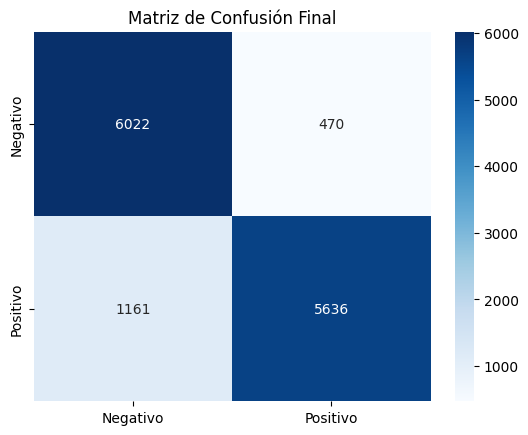

['final_pipeline.pkl']

In [ ]:
import optuna
from sklearn.metrics import f1_score, precision_recall_curve, auc
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las columnas (ejemplo)
ys = ['target']
binary_columns = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
id_columns = ['borrow_block_number']
wallet = ['wallet_address']
time_columns = [
    'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
    'time_since_first_deposit', 'time_since_last_liquidated','borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']

# Columnas a escalar
columns_to_scale = list(X0.columns.difference(id_columns + binary_columns + time_columns + ys + wallet))

# Preprocesador para escalar las columnas necesarias y pasar a través las demás
preprocessor = ColumnTransformer(
    transformers=[ 
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', id_columns + binary_columns + time_columns)
    ]
)

# Dividir en conjunto de entrenamiento (train) y conjunto de prueba (test)
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0, random_state=17)

# Ahora, dividir el conjunto de entrenamiento (X_train, y_train) en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=17)

# Asegurarse de que y_train y y_val sean vectores unidimensionales
y_train = y_train.values.flatten() if isinstance(y_train, pd.DataFrame) else y_train
y_val = y_val.values.flatten() if isinstance(y_val, pd.DataFrame) else y_val

# Función para crear el pipeline con parámetros configurables
# Función para crear el pipeline con parámetros configurables
def create_pipeline(model):
    return Pipeline([
        ('preprocessing', preprocessor),  # Preprocesamiento
        ('model', model)  # Modelo
    ])

# Crear la función objetivo para Optuna con Pruning
def objective(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 100, 300)  # Reducir el rango para acelerar la búsqueda
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 8)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    # Definir el modelo ExtraTreesClassifier con los hiperparámetros sugeridos
    model = ExtraTreesClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=123)
    
    # Crear el pipeline
    pipeline = create_pipeline(model)
    
    # Entrenar el modelo
    pipeline.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de validación
    y_pred = pipeline.predict(X_val)
    
    # Calcular F1 score
    f1 = f1_score(y_val, y_pred)
    
    # Calcular AUC-PR
    precision, recall, _ = precision_recall_curve(y_val, pipeline.predict_proba(X_val)[:, 1])
    auc_pr = auc(recall, precision)

    # Mostrar el rendimiento durante cada iteración
    print(f'F1 score en iteración {trial.number}: {f1}, AUC-PR: {auc_pr}')
    
    # Reportar solo el F1 score a Optuna
    trial.report(f1, trial.number)  # Reportar el F1 score

    # Pruning: Si el F1 es menor que el mejor, podar el ensayo
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()  # Podar el ensayo si no es prometedor
    
    return f1  # Queremos maximizar el F1 score

# Configurar y ejecutar el estudio Optuna
study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=200)  # Limitar a 200 ensayos

# Mejor conjunto de parámetros encontrados
best_params = study.best_params
print(f'Mejores parámetros encontrados: {best_params}')

# Crear el modelo final con los mejores parámetros
final_model = ExtraTreesClassifier(**best_params, random_state=123)

# Crear el pipeline final con el preprocesador
final_pipeline = create_pipeline(final_model)

# Entrenar el modelo final
final_pipeline.fit(X_train, y_train)

# Guardar el escalador (transformador) para uso posterior
joblib.dump(final_pipeline.named_steps['preprocessing'], 'scaler.pkl')

# Evaluación final en el conjunto de test con la métrica F1 y AUC-PR
final_y_pred = final_pipeline.predict(X_test)
final_f1 = f1_score(y_test, final_y_pred)
print(f'Rendimiento final (F1) en X_test: {final_f1}')

# Evaluar AUC-PR final
precision, recall, _ = precision_recall_curve(y_test, final_pipeline.predict_proba(X_test)[:, 1])
final_auc_pr = auc(recall, precision)
print(f'AUC-PR final: {final_auc_pr}') 

# Mostrar la matriz de confusión solo si el modelo es mejor
if final_f1 > initial_f1:
    final_cm = confusion_matrix(y_test, final_y_pred)
    sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.title('Matriz de Confusión Final')
    plt.show()

# Guardar el pipeline final para uso posterior
joblib.dump(final_pipeline, 'final_pipeline.pkl')

## Gráfico de coordenadas paralelas

In [48]:
import optuna
import plotly.express as px
import pandas as pd

# Obtener los resultados del estudio de Optuna
trials_df0 = study.trials
trials_data = []

# Extraer los parámetros y el valor de cada ensayo
for trial in trials_df0:
    # Extraer los parámetros y el F1 score
    trial_params = trial.params
    trial_params['F1 Score'] = trial.value  # Añadir el F1 score como una nueva columna
    trials_data.append(trial_params)

# Crear un DataFrame a partir de los resultados
trials_df = pd.DataFrame(trials_data)

# Verificar las columnas del DataFrame
print(trials_df.columns)

# Crear el gráfico de coordenadas paralelas
fig = px.parallel_coordinates(
    trials_df,
    dimensions=['n_estimators', 'max_depth', 'min_samples_split', 
                'min_samples_leaf', 'max_features', 'F1 Score'],
    color='F1 Score',  # Para colorear según el F1 score
    labels={
        'n_estimators': 'Número de Estimadores',
        'max_depth': 'Profundidad Máxima',
        'min_samples_split': 'Mínimo de Muestras para División',
        'min_samples_leaf': 'Mínimo de Muestras para Hoja',
        'max_features': 'Máximo de Características',
        'F1 Score': 'Puntaje F1'
    },
    color_continuous_scale='Blues',  # Cambiar el color del gráfico
    title="Paralel Coordinates: Parámetros y Rendimiento"
)

# Mostrar el gráfico
fig.show()

Index(['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf',
       'max_features', 'F1 Score'],
      dtype='object')


# Búsqueda final

In [ ]:
import optuna
from sklearn.metrics import f1_score, precision_recall_curve, auc
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las columnas (ejemplo)
ys = ['target']
binary_columns = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
id_columns = ['borrow_block_number']
wallet = ['wallet_address']
time_columns = [
    'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
    'time_since_first_deposit', 'time_since_last_liquidated','borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']

# Columnas a escalar
columns_to_scale = list(X0.columns.difference(id_columns + binary_columns + time_columns + ys + wallet))

# Preprocesador para escalar las columnas necesarias y pasar a través las demás
preprocessor = ColumnTransformer(
    transformers=[ 
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', id_columns + binary_columns + time_columns)
    ]
)

# Dividir en conjunto de entrenamiento (train) y conjunto de prueba (test)
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0, random_state=17)

# Ahora, dividir el conjunto de entrenamiento (X_train, y_train) en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=17)

# Asegurarse de que y_train y y_val sean vectores unidimensionales
y_train = y_train.values.flatten() if isinstance(y_train, pd.DataFrame) else y_train
y_val = y_val.values.flatten() if isinstance(y_val, pd.DataFrame) else y_val

# Función para crear el pipeline con parámetros configurables
# Función para crear el pipeline con parámetros configurables
def create_pipeline(model):
    return Pipeline([
        ('preprocessing', preprocessor),  # Preprocesamiento
        ('model', model)  # Modelo
    ])

# Crear la función objetivo para Optuna con Pruning
def objective(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 150, 250)  # Ajustado el rango de n_estimators
    max_depth = trial.suggest_int('max_depth', 25, 35)  # Ajustado el rango de max_depth
    min_samples_split = trial.suggest_int('min_samples_split', 2, 8)  # Se mantiene el mínimo
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)  # Ajustado el rango de min_samples_leaf
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    # Definir el modelo ExtraTreesClassifier con los hiperparámetros sugeridos
    model = ExtraTreesClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=123)
    
    # Crear el pipeline
    pipeline = create_pipeline(model)
    
    # Entrenar el modelo
    pipeline.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de validación
    y_pred = pipeline.predict(X_val)
    
    # Calcular F1 score
    f1 = f1_score(y_val, y_pred)
    
    # Calcular AUC-PR
    precision, recall, _ = precision_recall_curve(y_val, pipeline.predict_proba(X_val)[:, 1])
    auc_pr = auc(recall, precision)

    # Mostrar el rendimiento durante cada iteración
    print(f'F1 score en iteración {trial.number}: {f1}, AUC-PR: {auc_pr}')
    
    # Reportar solo el F1 score a Optuna
    trial.report(f1, trial.number)  # Reportar el F1 score

    # Pruning: Si el F1 es menor que el mejor, podar el ensayo
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()  # Podar el ensayo si no es prometedor
    
    return f1  # Queremos maximizar el F1 score

# Configurar y ejecutar el estudio Optuna
study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=100)  # Limitar a 200 ensayos

# Mejor conjunto de parámetros encontrados
best_params = study.best_params
print(f'Mejores parámetros encontrados: {best_params}')

# Crear el modelo final con los mejores parámetros
final_model = ExtraTreesClassifier(**best_params, random_state=123)

# Crear el pipeline final con el preprocesador
final_pipeline = create_pipeline(final_model)

# Entrenar el modelo final
final_pipeline.fit(X_train, y_train)

# Guardar el escalador (transformador) para uso posterior
joblib.dump(final_pipeline.named_steps['preprocessing'], 'scaler.pkl')

# Evaluación final en el conjunto de test con la métrica F1 y AUC-PR
final_y_pred = final_pipeline.predict(X_test)
final_f1 = f1_score(y_test, final_y_pred)
print(f'Rendimiento final (F1) en X_test: {final_f1}')

# Evaluar AUC-PR final
precision, recall, _ = precision_recall_curve(y_test, final_pipeline.predict_proba(X_test)[:, 1])
final_auc_pr = auc(recall, precision)
print(f'AUC-PR final: {final_auc_pr}') 

# Mostrar la matriz de confusión solo si el modelo es mejor
if final_f1 > initial_f1:
    final_cm = confusion_matrix(y_test, final_y_pred)
    sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.title('Matriz de Confusión Final')
    plt.show()

# Guardar el pipeline final para uso posterior
joblib.dump(final_pipeline, 'final_pipeline.pkl')

[I 2024-12-10 08:27:41,674] A new study created in memory with name: no-name-00a9cbd9-d444-4558-902c-d836d45e2a7e
[I 2024-12-10 08:29:30,363] Trial 0 finished with value: 0.8610372340425532 and parameters: {'n_estimators': 154, 'max_depth': 34, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.8610372340425532.


F1 score en iteración 0: 0.8610372340425532, AUC-PR: 0.9488398318902322


[I 2024-12-10 08:29:53,439] Trial 1 finished with value: 0.8618654073199528 and parameters: {'n_estimators': 195, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8618654073199528.


F1 score en iteración 1: 0.8618654073199528, AUC-PR: 0.9529114999840944


[I 2024-12-10 08:32:03,907] Trial 2 finished with value: 0.8677248677248677 and parameters: {'n_estimators': 222, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 2 with value: 0.8677248677248677.


F1 score en iteración 2: 0.8677248677248677, AUC-PR: 0.9528737921151845


[I 2024-12-10 08:34:00,328] Trial 3 finished with value: 0.858957219251337 and parameters: {'n_estimators': 206, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 0.8677248677248677.


F1 score en iteración 3: 0.858957219251337, AUC-PR: 0.949931589437224


[I 2024-12-10 08:34:14,057] Trial 4 finished with value: 0.8581103962072468 and parameters: {'n_estimators': 179, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8677248677248677.


F1 score en iteración 4: 0.8581103962072468, AUC-PR: 0.9489532744123722


[I 2024-12-10 08:36:01,595] Trial 5 finished with value: 0.859432387312187 and parameters: {'n_estimators': 217, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 2 with value: 0.8677248677248677.


F1 score en iteración 5: 0.859432387312187, AUC-PR: 0.9497818424500825


[I 2024-12-10 08:37:25,412] Trial 6 finished with value: 0.8638482023968043 and parameters: {'n_estimators': 155, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 2 with value: 0.8677248677248677.


F1 score en iteración 6: 0.8638482023968043, AUC-PR: 0.9515115952900154


[I 2024-12-10 08:37:50,231] Trial 7 finished with value: 0.8505356231933344 and parameters: {'n_estimators': 248, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.8677248677248677.


F1 score en iteración 7: 0.8505356231933344, AUC-PR: 0.9444650380684153


[I 2024-12-10 08:38:11,475] Trial 8 finished with value: 0.8559364972133086 and parameters: {'n_estimators': 184, 'max_depth': 33, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8677248677248677.


F1 score en iteración 8: 0.8559364972133086, AUC-PR: 0.9470982582385239


[I 2024-12-10 08:38:48,215] Trial 9 finished with value: 0.8592617562784426 and parameters: {'n_estimators': 249, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8677248677248677.


F1 score en iteración 9: 0.8592617562784426, AUC-PR: 0.9493549073050688


[I 2024-12-10 08:39:16,998] Trial 10 finished with value: 0.8725053603826488 and parameters: {'n_estimators': 221, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 10 with value: 0.8725053603826488.


F1 score en iteración 10: 0.8725053603826488, AUC-PR: 0.956046881908108


[I 2024-12-10 08:39:41,045] Trial 11 finished with value: 0.8729792147806005 and parameters: {'n_estimators': 225, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 11 with value: 0.8729792147806005.


F1 score en iteración 11: 0.8729792147806005, AUC-PR: 0.9560823958682184


[I 2024-12-10 08:40:02,245] Trial 12 finished with value: 0.873783204091734 and parameters: {'n_estimators': 230, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 12 with value: 0.873783204091734.


F1 score en iteración 12: 0.873783204091734, AUC-PR: 0.9562129473800443


[I 2024-12-10 08:40:25,555] Trial 13 finished with value: 0.8735973597359736 and parameters: {'n_estimators': 234, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 12 with value: 0.873783204091734.


F1 score en iteración 13: 0.8735973597359736, AUC-PR: 0.9561983731703336


[I 2024-12-10 08:40:43,446] Trial 14 finished with value: 0.8739803562510404 and parameters: {'n_estimators': 236, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 14 with value: 0.8739803562510404.


F1 score en iteración 14: 0.8739803562510404, AUC-PR: 0.9557663050941254


[I 2024-12-10 08:41:03,224] Trial 15 finished with value: 0.8711615487316422 and parameters: {'n_estimators': 237, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 14 with value: 0.8739803562510404.


F1 score en iteración 15: 0.8711615487316422, AUC-PR: 0.9545108476081252


[I 2024-12-10 08:41:19,314] Trial 16 finished with value: 0.8735632183908046 and parameters: {'n_estimators': 207, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 14 with value: 0.8739803562510404.


F1 score en iteración 16: 0.8735632183908046, AUC-PR: 0.9555665787624836


[I 2024-12-10 08:41:39,664] Trial 17 finished with value: 0.8710754843019372 and parameters: {'n_estimators': 237, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 14 with value: 0.8739803562510404.


F1 score en iteración 17: 0.8710754843019372, AUC-PR: 0.954780365714879


[I 2024-12-10 08:41:59,204] Trial 18 finished with value: 0.8712639839706128 and parameters: {'n_estimators': 233, 'max_depth': 34, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 14 with value: 0.8739803562510404.


F1 score en iteración 18: 0.8712639839706128, AUC-PR: 0.9549408434271915


[I 2024-12-10 08:42:16,787] Trial 19 finished with value: 0.8678929765886287 and parameters: {'n_estimators': 211, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 14 with value: 0.8739803562510404.


F1 score en iteración 19: 0.8678929765886287, AUC-PR: 0.9541026878434566


[I 2024-12-10 08:42:32,767] Trial 20 finished with value: 0.8624347533254757 and parameters: {'n_estimators': 197, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 14 with value: 0.8739803562510404.


F1 score en iteración 20: 0.8624347533254757, AUC-PR: 0.9518741262462352


[I 2024-12-10 08:42:55,472] Trial 21 finished with value: 0.8734949694870526 and parameters: {'n_estimators': 232, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 14 with value: 0.8739803562510404.


F1 score en iteración 21: 0.8734949694870526, AUC-PR: 0.9561573561476371


[I 2024-12-10 08:43:15,204] Trial 22 finished with value: 0.8740445330674643 and parameters: {'n_estimators': 244, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 22 with value: 0.8740445330674643.


F1 score en iteración 22: 0.8740445330674643, AUC-PR: 0.956988853945798


[I 2024-12-10 08:43:34,892] Trial 23 finished with value: 0.8740445330674643 and parameters: {'n_estimators': 244, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 22 with value: 0.8740445330674643.


F1 score en iteración 23: 0.8740445330674643, AUC-PR: 0.956988853945798


[I 2024-12-10 08:43:52,104] Trial 24 finished with value: 0.8744588744588745 and parameters: {'n_estimators': 244, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 24 with value: 0.8744588744588745.


F1 score en iteración 24: 0.8744588744588745, AUC-PR: 0.955736257918001


[I 2024-12-10 08:44:17,844] Trial 25 finished with value: 0.8609472442272038 and parameters: {'n_estimators': 245, 'max_depth': 31, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 24 with value: 0.8744588744588745.


F1 score en iteración 25: 0.8609472442272038, AUC-PR: 0.9498200950129768


[I 2024-12-10 08:44:42,506] Trial 26 finished with value: 0.8680509042196919 and parameters: {'n_estimators': 243, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 24 with value: 0.8744588744588745.


F1 score en iteración 26: 0.8680509042196919, AUC-PR: 0.9546269491408155


[I 2024-12-10 08:45:12,839] Trial 27 finished with value: 0.8701906992305118 and parameters: {'n_estimators': 250, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 24 with value: 0.8744588744588745.


F1 score en iteración 27: 0.8701906992305118, AUC-PR: 0.9545337847751126


[I 2024-12-10 08:45:45,908] Trial 28 finished with value: 0.8649647295935505 and parameters: {'n_estimators': 243, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.8744588744588745.


F1 score en iteración 28: 0.8649647295935505, AUC-PR: 0.9528553615860141


[I 2024-12-10 08:46:03,045] Trial 29 finished with value: 0.8665105386416861 and parameters: {'n_estimators': 215, 'max_depth': 34, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 24 with value: 0.8744588744588745.


F1 score en iteración 29: 0.8665105386416861, AUC-PR: 0.9529264503824147


## Gráfico de coordenadas paralelas (último)

In [ ]:
import optuna
import plotly.express as px
import pandas as pd

# Obtener los resultados del estudio de Optuna
trials_df0 = study.trials
trials_data = []

# Extraer los parámetros y el valor de cada ensayo
for trial in trials_df0:
    # Extraer los parámetros y el F1 score
    trial_params = trial.params
    trial_params['F1 Score'] = trial.value  # Añadir el F1 score como una nueva columna
    trials_data.append(trial_params)

# Crear un DataFrame a partir de los resultados
trials_df = pd.DataFrame(trials_data)

# Verificar las columnas del DataFrame
print(trials_df.columns)

# Crear el gráfico de coordenadas paralelas
fig = px.parallel_coordinates(
    trials_df,
    dimensions=['n_estimators', 'max_depth', 'min_samples_split', 
                'min_samples_leaf', 'max_features', 'F1 Score'],
    color='F1 Score',  # Para colorear según el F1 score
    labels={
        'n_estimators': 'Número de Estimadores',
        'max_depth': 'Profundidad Máxima',
        'min_samples_split': 'Mínimo de Muestras para División',
        'min_samples_leaf': 'Mínimo de Muestras para Hoja',
        'max_features': 'Máximo de Características',
        'F1 Score': 'Puntaje F1'
    },
    color_continuous_scale='Blues',  # Cambiar el color del gráfico
    title="Paralel Coordinates: Parámetros y Rendimiento"
)

# Mostrar el gráfico
fig.show()